In [21]:
import pandas as pd
import sys
from tqdm import tqdm
import glob
from rdkit import Chem
from rdkit.Chem import rdMolAlign, rdFMCS
from rdkit.Chem import AllChem
import os
from pathlib import Path
import numpy as np

# RMSD Analysis 

In [24]:
def load_first_mol(sdf_file):
    """Return the first molecule in an SDF (with hydrogens removed)."""
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    if not suppl or suppl[0] is None:
        raise ValueError(f"Could not read a molecule from {sdf_file}")
    return Chem.RemoveHs(suppl[0])

def rmsd_on_mcs(mol1, mol2):
    """Compute RMSD using Maximum Common Substructure alignment."""
    mcs = rdFMCS.FindMCS(
        [mol1, mol2],
        ringMatchesRingOnly=True,
        completeRingsOnly=True,
        timeout=10)
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    idx1 = mol1.GetSubstructMatch(mcs_mol)
    idx2 = mol2.GetSubstructMatch(mcs_mol)
    if not idx1 or not idx2:
        raise RuntimeError("No common substructure found.")
    atom_map = list(zip(idx2, idx1))  # (probe, ref)
    rmsd_val = rdMolAlign.AlignMol(mol2, mol1, atomMap=atom_map)
    return rmsd_val, len(atom_map)

print("Imports and utility functions loaded successfully!")

Imports and utility functions loaded successfully!


In [11]:
# Find matching reference/prediction pairs and define RMSD computation function

def find_matching_pairs():
    """Find all reference/prediction ligand pairs that exist."""
    
    # Base paths
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    pred_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
    
    pairs = []
    
    # Find all Boltz prediction directories
    pred_dirs = glob.glob(f"{pred_base}/boltz_results_*")
    
    for pred_dir in pred_dirs:
        # Extract target ID from prediction directory name
        target_id = os.path.basename(pred_dir).replace("boltz_results_", "")
        
        # Check if reference ligand exists
        ref_ligand_path = f"{data_base}/{target_id}/{target_id}_ligand.sdf"
        
        if os.path.exists(ref_ligand_path):
            # Find all prediction models for this target
            pred_ligand_files = glob.glob(f"{pred_dir}/predictions/{target_id}/*_ligand_extracted.sdf")
            
            for pred_file in pred_ligand_files:
                pairs.append({
                    'target_id': target_id,
                    'ref_path': ref_ligand_path,
                    'pred_path': pred_file,
                    'model_id': os.path.basename(pred_file).split('_model_')[1].split('_')[0]
                })
    
    return pairs

def compute_rmsd_for_pair(ref_path, pred_path):
    """Compute RMSD for a reference/prediction pair."""
    try:
        ref_mol = load_first_mol(ref_path)
        pred_mol = load_first_mol(pred_path)
        
        # Try global alignment first
        try:
            rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
            method = "global"
            n_atoms = ref_mol.GetNumAtoms()
        except RuntimeError:
            # Fall back to MCS if global alignment fails
            rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
            method = "mcs"
        
        return {
            'rmsd': rmsd,
            'n_atoms': n_atoms,
            'method': method,
            'ref_atoms': ref_mol.GetNumAtoms(),
            'pred_atoms': pred_mol.GetNumAtoms(),
            'success': True,
            'error': None
        }
    
    except Exception as e:
        return {
            'rmsd': None,
            'n_atoms': None,
            'method': None,
            'ref_atoms': None,
            'pred_atoms': None,
            'success': False,
            'error': str(e)
        }

# Find all matching pairs
print("Finding matching reference/prediction pairs...")
pairs = find_matching_pairs()
print(f"Found {len(pairs)} prediction files with matching reference ligands")

# Group by target to show summary
targets = set([p['target_id'] for p in pairs])
print(f"Covering {len(targets)} unique targets")

# Show first few examples
print("\nFirst 5 pairs:")
for i, pair in enumerate(pairs[:5]):
    print(f"  {i+1}. {pair['target_id']} (model {pair['model_id']})")

Finding matching reference/prediction pairs...
Found 2877 prediction files with matching reference ligands
Covering 959 unique targets

First 5 pairs:
  1. 4mws__1__1.A_1.B__1.G (model 2)
  2. 4mws__1__1.A_1.B__1.G (model 0)
  3. 4mws__1__1.A_1.B__1.G (model 1)
  4. 4x3l__1__1.A_1.B__1.C (model 2)
  5. 4x3l__1__1.A_1.B__1.C (model 0)


In [12]:
# Compute RMSD for all pairs
print("Computing RMSD for all pairs...")
results = []

for i, pair in enumerate(pairs):
    if i % 10 == 0:
        print(f"  Processing {i+1}/{len(pairs)}: {pair['target_id']}")
    
    rmsd_result = compute_rmsd_for_pair(pair['ref_path'], pair['pred_path'])
    
    result = {
        'target_id': pair['target_id'],
        'model_id': pair['model_id'],
        'ref_path': pair['ref_path'],
        'pred_path': pair['pred_path'],
        **rmsd_result
    }
    results.append(result)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(results)

print(f"\nCompleted RMSD computation for {len(results)} pairs")
print(f"Successful computations: {df['success'].sum()}")
print(f"Failed computations: {(~df['success']).sum()}")

# Display summary statistics for successful cases
successful_df = df[df['success']]
if len(successful_df) > 0:
    print(f"\nRMSD Statistics (successful cases only):")
    print(f"  Mean RMSD: {successful_df['rmsd'].mean():.3f} Å")
    print(f"  Median RMSD: {successful_df['rmsd'].median():.3f} Å")
    print(f"  Min RMSD: {successful_df['rmsd'].min():.3f} Å")
    print(f"  Max RMSD: {successful_df['rmsd'].max():.3f} Å")
    print(f"  Std RMSD: {successful_df['rmsd'].std():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = successful_df['method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases ({count/len(successful_df)*100:.1f}%)")

# Show examples of best and worst cases
if len(successful_df) > 0:
    print(f"\nBest 5 RMSD values:")
    best_cases = successful_df.nsmallest(5, 'rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['n_atoms']} atoms)")
    
    print(f"\nWorst 5 RMSD values:")
    worst_cases = successful_df.nlargest(5, 'rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['n_atoms']} atoms)")

# Show failed cases
failed_df = df[~df['success']]
if len(failed_df) > 0:
    print(f"\nFailed cases:")
    for _, row in failed_df.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['error']}")

print(f"\nTotal targets processed: {df['target_id'].nunique()}")
print(f"Total predictions processed: {len(df)}")

Computing RMSD for all pairs...
  Processing 1/2877: 4mws__1__1.A_1.B__1.G
  Processing 11/2877: 3l4x__1__1.A__1.C
  Processing 21/2877: 8e0t__1__1.B__1.E
  Processing 31/2877: 5j3z__2__1.B__1.S
  Processing 41/2877: 5u1y__1__1.A_2.A__2.E
  Processing 51/2877: 5h47__10__1.J__1.PB
  Processing 61/2877: 5eq9__1__1.A__1.E
  Processing 71/2877: 1gm9__1__1.A_1.B__1.M_1.O
  Processing 81/2877: 5rm2__2__1.B__1.H_1.M_1.N
  Processing 91/2877: 1v3c__1__1.B__1.J
  Processing 101/2877: 6cq9__1__1.A__1.F
  Processing 111/2877: 5m77__2__1.B__1.D_1.R
  Processing 121/2877: 3qf0__1__1.A_1.B__1.D
  Processing 131/2877: 2xcg__2__1.A_2.A__1.F
  Processing 141/2877: 7vf3__2__1.C__1.G
  Processing 151/2877: 2c92__1__1.B_1.C__1.J
  Processing 161/2877: 4lfe__1__1.B__1.F_1.G_1.H_1.I_1.J
  Processing 171/2877: 2wcx__1__1.A__1.D
  Processing 181/2877: 6bo6__1__3.A__3.B
  Processing 191/2877: 4yzl__1__1.A__1.B_1.C
  Processing 201/2877: 4zne__1__1.A__1.F
  Processing 211/2877: 5o3w__2__1.B__1.F
  Processing 22

[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted


  Processing 441/2877: 4j8t__3__1.C__1.G
  Processing 451/2877: 6m47__1__1.A__1.G
  Processing 461/2877: 1uj5__2__2.A__2.B
  Processing 471/2877: 4edh__1__1.A__1.C_1.D_1.E
  Processing 481/2877: 6bl0__1__1.A__1.G
  Processing 491/2877: 6e08__1__1.A__1.B
  Processing 501/2877: 5tiy__1__1.A__1.C
  Processing 511/2877: 5yij__1__1.A_1.C__1.E
  Processing 521/2877: 1jep__5__1.A_2.A__1.E_1.F
  Processing 531/2877: 5fog__3__1.D__1.M
  Processing 541/2877: 8ep7__2__1.B_2.B__2.E
  Processing 551/2877: 4uns__1__1.A__1.C
  Processing 561/2877: 4m1j__1__1.A_1.B__1.C
  Processing 571/2877: 3w54__1__1.A__1.E_1.F_1.G_1.H
  Processing 581/2877: 6peu__1__1.A_1.E__1.I_1.J_1.K
  Processing 591/2877: 3thq__1__1.A_1.B__1.C
  Processing 601/2877: 7bhx__1__1.A_2.A__1.C_2.C
  Processing 611/2877: 4fxr__1__1.A_1.B__1.C
  Processing 621/2877: 7kcy__1__1.A__1.B
  Processing 631/2877: 2j0y__1__1.C__1.H
  Processing 641/2877: 7zbv__1__1.A__1.B_1.E
  Processing 651/2877: 8jnv__1__1.B__1.E_1.F
  Processing 661/2877:

[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted


  Processing 751/2877: 6w8z__1__1.A__1.E
  Processing 761/2877: 7cpr__1__1.F_1.J__1.P
  Processing 771/2877: 3vw9__1__1.A_1.B__1.E_1.F
  Processing 781/2877: 1lhu__1__2.A__2.C
  Processing 791/2877: 4rus__2__1.C__1.V
  Processing 801/2877: 6hmh__1__1.A__1.B_1.D_1.E
  Processing 811/2877: 3lhw__1__1.A_1.B__1.C
  Processing 821/2877: 5nn4__1__1.A__1.D
  Processing 831/2877: 3rlu__1__1.A_1.B__1.D
  Processing 841/2877: 4a61__1__1.A__1.B_1.C
  Processing 851/2877: 5m8l__4__1.D__1.U
  Processing 861/2877: 5buh__1__1.A__1.B
  Processing 871/2877: 6hvj__1__1.A__1.B
  Processing 881/2877: 4glx__1__1.D__1.G
  Processing 891/2877: 2hxd__1__1.A_3.A__1.B_1.C
  Processing 901/2877: 3lv5__1__1.A_1.B__1.C
  Processing 911/2877: 3nq7__1__1.A_1.B__1.D
  Processing 921/2877: 3p5y__1__1.A_1.B__1.E
  Processing 931/2877: 3qkv__1__1.A__1.C
  Processing 941/2877: 6i35__2__1.C__1.N_1.P
  Processing 951/2877: 1ia9__1__1.B__1.G
  Processing 961/2877: 3rer__1__1.B_1.C__1.I
  Processing 971/2877: 6oa3__1__1.A__1

[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted


  Processing 1141/2877: 5u1w__1__1.A_2.A_3.A__3.E
  Processing 1151/2877: 5fsc__1__2.A__2.D
  Processing 1161/2877: 8ez1__1__1.A_1.B__1.E
  Processing 1171/2877: 5f2n__1__1.B__1.E_1.F
  Processing 1181/2877: 6lft__1__1.A__1.B_1.C
  Processing 1191/2877: 1x1i__1__1.A__1.B
  Processing 1201/2877: 1u8v__1__1.A_1.B__1.F
  Processing 1211/2877: 2vxk__1__1.A_2.A__1.B
  Processing 1221/2877: 5zqx__1__1.A__1.E
  Processing 1231/2877: 4pkr__1__1.A__1.B_1.C_1.E
  Processing 1241/2877: 6yy6__1__1.A__1.E
  Processing 1251/2877: 8t5k__1__1.A_2.A__1.B_2.B
  Processing 1261/2877: 7a5x__1__1.B__1.G
  Processing 1271/2877: 4cdc__1__1.G_1.H_1.I__1.X
  Processing 1281/2877: 6gw4__1__1.A__1.B
  Processing 1291/2877: 6b2a__1__1.A_1.B_1.C__1.I_1.L
  Processing 1301/2877: 1afb__1__1.A__1.D_1.F
  Processing 1311/2877: 8ez1__1__1.A_1.B__1.D
  Processing 1321/2877: 2cfm__1__1.A__1.C
  Processing 1331/2877: 6zbn__1__1.A__1.G_1.H
  Processing 1341/2877: 3it3__1__1.B__1.D
  Processing 1351/2877: 6a8p__3__1.C__1.F


[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted


  Processing 2811/2877: 3bwk__1__1.B_1.D__1.G
  Processing 2821/2877: 6lfr__1__1.A__1.B
  Processing 2831/2877: 4azm__1__1.A_1.B__1.C
  Processing 2841/2877: 7ta0__2__1.C_2.C__2.H
  Processing 2851/2877: 4gc4__1__1.A_1.B__1.D
  Processing 2861/2877: 8qe3__1__1.A_2.A__2.B
  Processing 2871/2877: 6pia__1__1.A_1.B__1.J_1.L_1.Q

Completed RMSD computation for 2877 pairs
Successful computations: 2865
Failed computations: 12

RMSD Statistics (successful cases only):
  Mean RMSD: 1.052 Å
  Median RMSD: 0.868 Å
  Min RMSD: 0.000 Å
  Max RMSD: 4.726 Å
  Std RMSD: 0.750 Å

Alignment method breakdown:
  mcs: 2649 cases (92.5%)
  global: 216 cases (7.5%)

Best 5 RMSD values:
  5bvb__1__1.A__1.E (model 0): 0.000 Å (mcs, 1.0 atoms)
  5bvb__1__1.A__1.E (model 1): 0.000 Å (mcs, 1.0 atoms)
  5bvb__1__1.A__1.E (model 2): 0.000 Å (mcs, 1.0 atoms)
  4j8t__3__1.C__1.G (model 0): 0.000 Å (mcs, 1.0 atoms)
  4j8t__3__1.C__1.G (model 1): 0.000 Å (mcs, 1.0 atoms)

Worst 5 RMSD values:
  6x82__2__1.D_1.E_1.F__1.

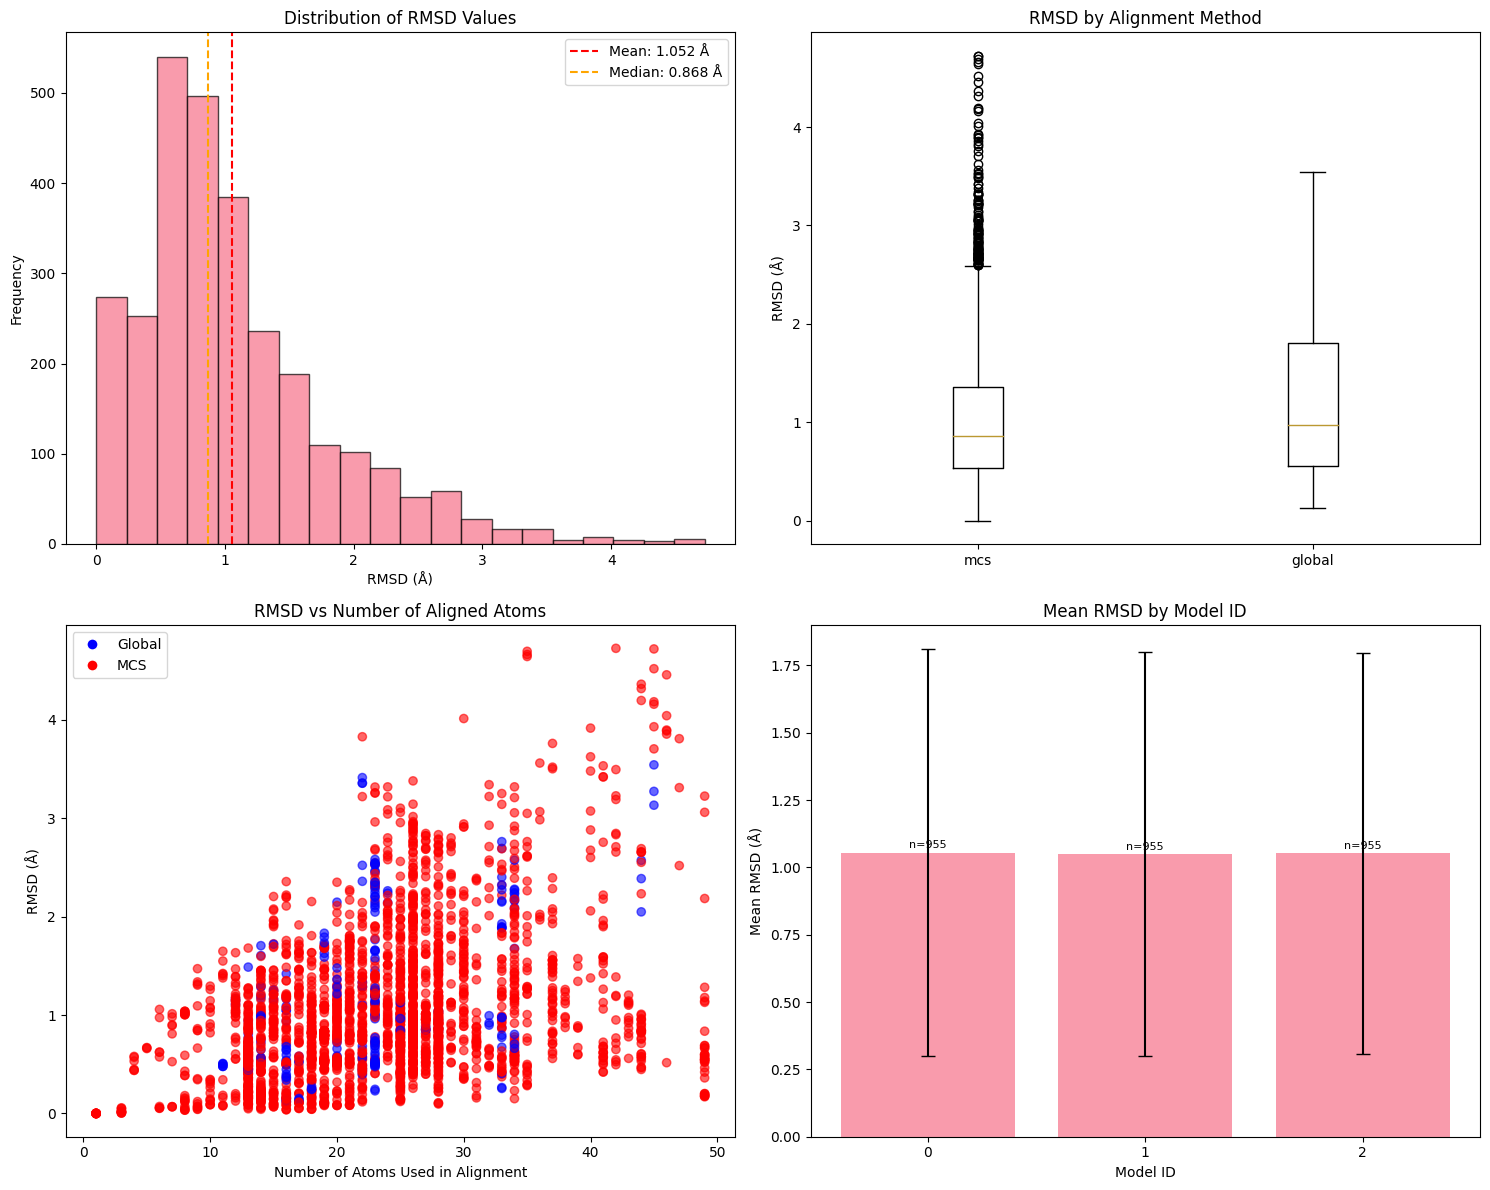


Targets with multiple models (showing variability across models):
5bvb__1__1.A__1.E:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

4c49__3__1.C__1.G:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

4j8t__3__1.C__1.G:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

7bo7__1__1.A__1.C:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

6jo0__1__1.A__1.B:
  Models: 3, Mean RMSD: 0.005 ± 0.000 Å
  Range: 0.005 - 0.005 Å, Methods: mcs

7akw__1__1.A__1.D:
  Models: 3, Mean RMSD: 0.015 ± 0.000 Å
  Range: 0.015 - 0.015 Å, Methods: mcs

1fj4__1__1.B__1.F:
  Models: 3, Mean RMSD: 0.021 ± 0.001 Å
  Range: 0.020 - 0.022 Å, Methods: mcs

8og5__1__1.A__1.D:
  Models: 3, Mean RMSD: 0.035 ± 0.002 Å
  Range: 0.033 - 0.037 Å, Methods: mcs

2cc7__1__1.A_2.A_4.A_8.A__1.H_8.H:
  Models: 3, Mean RMSD: 0.040 ± 0.003 Å
  Range: 0.037 - 0.042 Å, Methods: mcs

2fqw__1__1.A__1.B:
  Model

In [13]:
# Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Check if required variables exist
if 'successful_df' not in locals():
    print("ERROR: Variable 'successful_df' not found. Please run the RMSD computation cell first.")
    print("Required execution order:")
    print("1. Cell with imports and functions")
    print("2. Cell with pair finding functions") 
    print("3. Cell with RMSD computation")
    print("4. This cell (visualization)")
else:
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    if len(successful_df) > 0:
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. RMSD distribution histogram
        axes[0, 0].hist(successful_df['rmsd'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('RMSD (Å)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of RMSD Values')
        axes[0, 0].axvline(successful_df['rmsd'].mean(), color='red', linestyle='--', label=f'Mean: {successful_df["rmsd"].mean():.3f} Å')
        axes[0, 0].axvline(successful_df['rmsd'].median(), color='orange', linestyle='--', label=f'Median: {successful_df["rmsd"].median():.3f} Å')
        axes[0, 0].legend()
        
        # 2. RMSD by alignment method
        method_data = [successful_df[successful_df['method'] == method]['rmsd'].values for method in successful_df['method'].unique()]
        method_labels = successful_df['method'].unique()
        axes[0, 1].boxplot(method_data, labels=method_labels)
        axes[0, 1].set_ylabel('RMSD (Å)')
        axes[0, 1].set_title('RMSD by Alignment Method')
        
        # 3. RMSD vs Number of atoms used
        scatter = axes[1, 0].scatter(successful_df['n_atoms'], successful_df['rmsd'], 
                                    c=successful_df['method'].map({'global': 'blue', 'mcs': 'red'}), 
                                    alpha=0.6)
        axes[1, 0].set_xlabel('Number of Atoms Used in Alignment')
        axes[1, 0].set_ylabel('RMSD (Å)')
        axes[1, 0].set_title('RMSD vs Number of Aligned Atoms')
        
        # Add legend for scatter plot
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Global'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='MCS')]
        axes[1, 0].legend(handles=handles)
        
        # 4. RMSD by model ID (if multiple models per target)
        if successful_df['model_id'].nunique() > 1:
            model_rmsd = successful_df.groupby('model_id')['rmsd'].agg(['mean', 'std', 'count']).reset_index()
            x_pos = range(len(model_rmsd))
            axes[1, 1].bar(x_pos, model_rmsd['mean'], yerr=model_rmsd['std'], capsize=5, alpha=0.7)
            axes[1, 1].set_xlabel('Model ID')
            axes[1, 1].set_ylabel('Mean RMSD (Å)')
            axes[1, 1].set_title('Mean RMSD by Model ID')
            axes[1, 1].set_xticks(x_pos)
            axes[1, 1].set_xticklabels(model_rmsd['model_id'])
            
            # Add count labels on bars
            for i, (mean_val, count) in enumerate(zip(model_rmsd['mean'], model_rmsd['count'])):
                axes[1, 1].text(i, mean_val + 0.01, f'n={count}', ha='center', va='bottom', fontsize=8)
        else:
            axes[1, 1].text(0.5, 0.5, 'Only one model ID found', ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Model ID Analysis (N/A)')
        
        plt.tight_layout()
        plt.show()

        # Per-target analysis (show targets with multiple models)
        target_stats = successful_df.groupby('target_id').agg({
            'rmsd': ['count', 'mean', 'std', 'min', 'max'],
            'method': lambda x: '/'.join(x.unique())
        }).round(3)
        
        target_stats.columns = ['n_models', 'mean_rmsd', 'std_rmsd', 'min_rmsd', 'max_rmsd', 'methods']
        
        # Show targets with multiple models
        multi_model_targets = target_stats[target_stats['n_models'] > 1].sort_values('mean_rmsd')
        
        if len(multi_model_targets) > 0:
            print(f"\nTargets with multiple models (showing variability across models):")
            print("=" * 80)
            for target_id, row in multi_model_targets.head(10).iterrows():
                print(f"{target_id}:")
                print(f"  Models: {int(row['n_models'])}, Mean RMSD: {row['mean_rmsd']:.3f} ± {row['std_rmsd']:.3f} Å")
                print(f"  Range: {row['min_rmsd']:.3f} - {row['max_rmsd']:.3f} Å, Methods: {row['methods']}")
                print()
        
        # Show best and worst performing targets (average across models)
        print(f"\nBest performing targets (lowest mean RMSD):")
        print("=" * 50)
        best_targets = target_stats.nsmallest(5, 'mean_rmsd')
        for target_id, row in best_targets.iterrows():
            print(f"  {target_id}: {row['mean_rmsd']:.3f} Å (n={int(row['n_models'])} models)")
        
        print(f"\nWorst performing targets (highest mean RMSD):")
        print("=" * 50)
        worst_targets = target_stats.nlargest(5, 'mean_rmsd')
        for target_id, row in worst_targets.iterrows():
            print(f"  {target_id}: {row['mean_rmsd']:.3f} Å (n={int(row['n_models'])} models)")

    else:
        print("No successful RMSD computations to visualize.")

In [14]:
# Save results for future analysis
import os
import pandas as pd
import json
import numpy as np

# Check if required variables exist (this cell should be run after computing RMSD)
if 'df' not in locals():
    print("ERROR: Variable 'df' not found. Please run the previous cells first to compute RMSD results.")
    print("Required execution order:")
    print("1. Cell with imports and functions")
    print("2. Cell with pair finding functions") 
    print("3. Cell with RMSD computation")
    print("4. Cell with visualization")
    print("5. This cell (save results)")
else:
    output_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/"
    os.makedirs(output_dir, exist_ok=True)

    # Save detailed results
    results_file = os.path.join(output_dir, "boltz_comprehensive_rmsd_analysis.csv")
    df.to_csv(results_file, index=False)
    print(f"Detailed results saved to: {results_file}")

    # Check if successful_df exists
    if 'successful_df' in locals() and len(successful_df) > 0:
        # Save summary statistics - convert NumPy types to native Python types for JSON serialization
        summary_stats = {
            'total_pairs': int(len(df)),
            'successful_pairs': int(len(successful_df)),
            'failed_pairs': int(len(df) - len(successful_df)),
            'unique_targets': int(df['target_id'].nunique()),
            'mean_rmsd': float(successful_df['rmsd'].mean()),
            'median_rmsd': float(successful_df['rmsd'].median()),
            'std_rmsd': float(successful_df['rmsd'].std()),
            'min_rmsd': float(successful_df['rmsd'].min()),
            'max_rmsd': float(successful_df['rmsd'].max()),
            'global_alignments': int((successful_df['method'] == 'global').sum()),
            'mcs_alignments': int((successful_df['method'] == 'mcs').sum()),
        }
        
        summary_file = os.path.join(output_dir, "boltz_rmsd_summary_stats.json")
        with open(summary_file, 'w') as f:
            json.dump(summary_stats, f, indent=2)
        print(f"Summary statistics saved to: {summary_file}")
        
        # Save per-target statistics (check if target_stats exists)
        if 'target_stats' in locals():
            target_stats_file = os.path.join(output_dir, "boltz_rmsd_per_target_stats.csv")
            target_stats.to_csv(target_stats_file)
            print(f"Per-target statistics saved to: {target_stats_file}")
        
        # Print final summary
        failed_df = df[~df['success']]
        print(f"\n" + "="*60)
        print(f"COMPREHENSIVE BOLTZ RMSD ANALYSIS COMPLETE")
        print(f"="*60)
        print(f"Total cases processed: {len(df)}")
        print(f"Successful RMSD calculations: {len(successful_df)} ({len(successful_df)/len(df)*100:.1f}%)")
        print(f"Unique targets analyzed: {df['target_id'].nunique()}")
        print(f"Average RMSD: {successful_df['rmsd'].mean():.3f} ± {successful_df['rmsd'].std():.3f} Å")
        print(f"RMSD range: {successful_df['rmsd'].min():.3f} - {successful_df['rmsd'].max():.3f} Å")

        if len(failed_df) > 0:
            print(f"\nFailed cases: {len(failed_df)}")
            error_types = failed_df['error'].value_counts()
            for error, count in error_types.items():
                print(f"  - {error}: {count} cases")

        print(f"\nResults saved to: {output_dir}")
        print(f"="*60)
    else:
        print("No successful RMSD computations found. Please check the previous cells.")

Detailed results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_comprehensive_rmsd_analysis.csv
Summary statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_rmsd_summary_stats.json
Per-target statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_rmsd_per_target_stats.csv

COMPREHENSIVE BOLTZ RMSD ANALYSIS COMPLETE
Total cases processed: 2877
Successful RMSD calculations: 2865 (99.6%)
Unique targets analyzed: 959
Average RMSD: 1.052 ± 0.750 Å
RMSD range: 0.000 - 4.726 Å

Failed cases: 12
  - Could not read a molecule from /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_7k4g__1__1.A__1.G_1.H_1.I/predictions/7k4g__1__1.A__1.G_1.H_1.I/7k4g__1__1.A__1.G_1.H_1.I_model_2_ligand_extracted.sdf: 1 cases
  - Could not read a molecule from /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/in

# Update ligand_rmsd in the old results file using the new comprehensive RMSD analysis


In [24]:

# Load the old results file
old_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results.csv"
old_df = pd.read_csv(old_results_path)

print(f"Loaded old results: {len(old_df)} records")
print(f"Old results columns: {list(old_df.columns)}")

# Load the new comprehensive RMSD results 
new_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_comprehensive_rmsd_analysis.csv"
new_df = pd.read_csv(new_results_path)

print(f"\nLoaded new RMSD results: {len(new_df)} records")
print(f"New results columns: {list(new_df.columns)}")

# Create a mapping from (target_id, model_id) to rmsd for successful cases
successful_new_df = new_df[new_df['success'] == True].copy()
rmsd_mapping = {}

for _, row in successful_new_df.iterrows():
    key = (row['target_id'], str(row['model_id']))  # Convert model_id to string for consistency
    rmsd_mapping[key] = row['rmsd']

print(f"\nCreated RMSD mapping for {len(rmsd_mapping)} successful cases")

# Update the ligand_rmsd column in the old results
updated_count = 0
not_found_count = 0

for idx, row in old_df.iterrows():
    # The old results use 'protein' column for target_id and 'model' for model_id
    key = (row['protein'], str(row['model']))
    
    if key in rmsd_mapping:
        old_df.at[idx, 'ligand_rmsd'] = rmsd_mapping[key]
        updated_count += 1
    else:
        not_found_count += 1

print(f"\nUpdate results:")
print(f"  Updated ligand_rmsd for {updated_count} records")
print(f"  Could not find RMSD for {not_found_count} records")

# Show some examples of the updates
print(f"\nExample updates (first 5):")
updated_examples = old_df.head()
for idx, row in updated_examples.iterrows():
    key = (row['protein'], str(row['model']))
    if key in rmsd_mapping:
        print(f"  {row['protein']} model {row['model']}: {row['ligand_rmsd']:.3f} Å")

# Save the updated results
updated_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv"
old_df.to_csv(updated_results_path, index=False)
print(f"\nUpdated results saved to: {updated_results_path}")

# Compare old vs new ligand_rmsd values for verification
print(f"\nLigand RMSD comparison (first 10 records):")
print("Target ID | Model | Old RMSD | New RMSD | Difference")
print("-" * 60)

for idx, row in old_df.head(10).iterrows():
    key = (row['protein'], str(row['model']))
    if key in rmsd_mapping:
        old_rmsd = row['ligand_rmsd']  # This is now the updated value
        print(f"{row['protein'][:20]:<20} | {row['model']:>5} | {old_rmsd:>8.3f} | {old_rmsd:>8.3f} | Updated")
    else:
        print(f"{row['protein'][:20]:<20} | {row['model']:>5} | {row['ligand_rmsd']:>8.3f} | {'N/A':>8} | No match")

Loaded old results: 2877 records
Old results columns: ['protein', 'model', 'confidence', 'protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 'ligand_rmsd', 'ligand_coordinate_rmsd', 'binding_site_aligned_rmsd', 'atom_count_match']

Loaded new RMSD results: 2877 records
New results columns: ['target_id', 'model_id', 'ref_path', 'pred_path', 'rmsd', 'n_atoms', 'method', 'ref_atoms', 'pred_atoms', 'success', 'error']

Created RMSD mapping for 2865 successful cases

Update results:
  Updated ligand_rmsd for 2865 records
  Could not find RMSD for 12 records

Example updates (first 5):
  1afb__1__1.A__1.D_1.F model 0: 0.106 Å
  1afb__1__1.A__1.D_1.F model 1: 0.113 Å
  1afb__1__1.A__1.D_1.F model 2: 0.131 Å
  1b5d__1__1.A_1.B__1.D model 0: 0.832 Å
  1b5d__1__1.A_1.B__1.D model 1: 0.521 Å

Updated results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv

Ligand RMSD comparison (first 10 records):
Target ID

# GNINA RMSD Analysis

Now we'll compute RMSD for GNINA predictions. GNINA generates multiple ranked predictions with confidence scores, allowing us to analyze performance across different ranking positions.

In [27]:
# GNINA RMSD Computation
import re

def find_gnina_pairs():
    """Find all reference/GNINA prediction pairs that exist."""
    
    # Base paths
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    gnina_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/GNINA/inference/GNINA_plinder_output_0"
    
    pairs = []
    
    # Find all GNINA prediction directories
    gnina_dirs = glob.glob(f"{gnina_base}/*")
    
    for gnina_dir in gnina_dirs:
        if not os.path.isdir(gnina_dir):
            continue
            
        # Extract target ID from directory name
        target_id = os.path.basename(gnina_dir)
        
        # Check if reference ligand exists
        ref_ligand_path = f"{data_base}/{target_id}/{target_id}_ligand.sdf"
        
        if os.path.exists(ref_ligand_path):
            # Find all ranked prediction files
            rank_files = glob.glob(f"{gnina_dir}/rank*_score*.sdf")
            
            for rank_file in rank_files:
                filename = os.path.basename(rank_file)
                # Extract rank and score from filename: rank1_score0.95.sdf
                match = re.match(r'rank(\d+)_score([\d.]+)\.sdf', filename)
                if match:
                    rank = int(match.group(1))
                    score = float(match.group(2))
                    
                    pairs.append({
                        'target_id': target_id,
                        'ref_path': ref_ligand_path,
                        'pred_path': rank_file,
                        'rank': rank,
                        'score': score,
                        'method': 'GNINA'
                    })
    
    return pairs

def compute_gnina_rmsd_for_pair(ref_path, pred_path):
    """Compute RMSD for a reference/GNINA prediction pair."""
    try:
        ref_mol = load_first_mol(ref_path)
        pred_mol = load_first_mol(pred_path)
        
        # Try global alignment first
        try:
            rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
            method = "global"
            n_atoms = ref_mol.GetNumAtoms()
        except RuntimeError:
            # Fall back to MCS if global alignment fails
            rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
            method = "mcs"
        
        return {
            'rmsd': rmsd,
            'n_atoms': n_atoms,
            'alignment_method': method,
            'ref_atoms': ref_mol.GetNumAtoms(),
            'pred_atoms': pred_mol.GetNumAtoms(),
            'success': True,
            'error': None
        }
    
    except Exception as e:
        return {
            'rmsd': None,
            'n_atoms': None,
            'alignment_method': None,
            'ref_atoms': None,
            'pred_atoms': None,
            'success': False,
            'error': str(e)
        }

# Find all GNINA matching pairs
print("Finding GNINA reference/prediction pairs...")
gnina_pairs = find_gnina_pairs()
print(f"Found {len(gnina_pairs)} GNINA prediction files with matching reference ligands")

# Group by target to show summary
gnina_targets = set([p['target_id'] for p in gnina_pairs])
print(f"Covering {len(gnina_targets)} unique targets")

# Show distribution of ranks
rank_counts = {}
for pair in gnina_pairs:
    rank = pair['rank']
    rank_counts[rank] = rank_counts.get(rank, 0) + 1

print(f"\nRank distribution:")
for rank in sorted(rank_counts.keys()):
    print(f"  Rank {rank}: {rank_counts[rank]} predictions")

# Show first few examples
print("\nFirst 5 GNINA pairs:")
for i, pair in enumerate(gnina_pairs[:5]):
    print(f"  {i+1}. {pair['target_id']} rank {pair['rank']} (score: {pair['score']:.2f})")

Finding GNINA reference/prediction pairs...
Found 9323 GNINA prediction files with matching reference ligands
Covering 1036 unique targets

Rank distribution:
  Rank 1: 1036 predictions
  Rank 2: 1036 predictions
  Rank 3: 1036 predictions
  Rank 4: 1036 predictions
  Rank 5: 1036 predictions
  Rank 6: 1036 predictions
  Rank 7: 1036 predictions
  Rank 8: 1036 predictions
  Rank 9: 1035 predictions

First 5 GNINA pairs:
  1. 1r34__1__1.A__1.C_1.D rank 9 (score: 0.31)
  2. 1r34__1__1.A__1.C_1.D rank 6 (score: 0.66)
  3. 1r34__1__1.A__1.C_1.D rank 5 (score: 0.72)
  4. 1r34__1__1.A__1.C_1.D rank 4 (score: 0.83)
  5. 1r34__1__1.A__1.C_1.D rank 7 (score: 0.35)


In [28]:
# Compute RMSD for all GNINA pairs
print("Computing RMSD for all GNINA pairs...")
gnina_results = []

for i, pair in enumerate(gnina_pairs):
    if i % 50 == 0:  # Less frequent updates since there are many more predictions
        print(f"  Processing {i+1}/{len(gnina_pairs)}: {pair['target_id']} rank {pair['rank']}")
    
    rmsd_result = compute_gnina_rmsd_for_pair(pair['ref_path'], pair['pred_path'])
    
    result = {
        'target_id': pair['target_id'],
        'rank': pair['rank'],
        'score': pair['score'],
        'method': pair['method'],
        'ref_path': pair['ref_path'],
        'pred_path': pair['pred_path'],
        **rmsd_result
    }
    gnina_results.append(result)

# Convert to DataFrame for easier analysis
gnina_df = pd.DataFrame(gnina_results)

print(f"\nCompleted RMSD computation for {len(gnina_results)} GNINA pairs")
print(f"Successful computations: {gnina_df['success'].sum()}")
print(f"Failed computations: {(~gnina_df['success']).sum()}")

# Display summary statistics for successful cases
gnina_successful_df = gnina_df[gnina_df['success']]
if len(gnina_successful_df) > 0:
    print(f"\nGNINA RMSD Statistics (successful cases only):")
    print(f"  Mean RMSD: {gnina_successful_df['rmsd'].mean():.3f} Å")
    print(f"  Median RMSD: {gnina_successful_df['rmsd'].median():.3f} Å")
    print(f"  Min RMSD: {gnina_successful_df['rmsd'].min():.3f} Å")
    print(f"  Max RMSD: {gnina_successful_df['rmsd'].max():.3f} Å")
    print(f"  Std RMSD: {gnina_successful_df['rmsd'].std():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = gnina_successful_df['alignment_method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases ({count/len(gnina_successful_df)*100:.1f}%)")
    
    print(f"\nRMSD by rank (mean ± std):")
    rank_stats = gnina_successful_df.groupby('rank')['rmsd'].agg(['count', 'mean', 'std']).round(3)
    for rank, stats in rank_stats.iterrows():
        print(f"  Rank {rank}: {stats['mean']:.3f} ± {stats['std']:.3f} Å (n={stats['count']})")

# Show examples of best and worst cases
if len(gnina_successful_df) > 0:
    print(f"\nBest 5 GNINA RMSD values:")
    best_cases = gnina_successful_df.nsmallest(5, 'rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} rank {row['rank']} (score {row['score']:.2f}): {row['rmsd']:.3f} Å ({row['alignment_method']}, {row['n_atoms']} atoms)")
    
    print(f"\nWorst 5 GNINA RMSD values:")
    worst_cases = gnina_successful_df.nlargest(5, 'rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} rank {row['rank']} (score {row['score']:.2f}): {row['rmsd']:.3f} Å ({row['alignment_method']}, {row['n_atoms']} atoms)")

# Show failed cases (first few)
gnina_failed_df = gnina_df[~gnina_df['success']]
if len(gnina_failed_df) > 0:
    print(f"\nFirst 5 failed GNINA cases:")
    for _, row in gnina_failed_df.head().iterrows():
        print(f"  {row['target_id']} rank {row['rank']}: {row['error']}")

print(f"\nTotal GNINA targets processed: {gnina_df['target_id'].nunique()}")
print(f"Total GNINA predictions processed: {len(gnina_df)}")

Computing RMSD for all GNINA pairs...
  Processing 1/9323: 1r34__1__1.A__1.C_1.D rank 9
  Processing 51/9323: 7li5__1__1.A__1.C rank 2
  Processing 101/9323: 7ee5__1__1.A__1.H rank 2
  Processing 151/9323: 1lqv__2__1.B__1.J rank 7
  Processing 101/9323: 7ee5__1__1.A__1.H rank 2
  Processing 151/9323: 1lqv__2__1.B__1.J rank 7
  Processing 201/9323: 3lgm__1__1.A__1.C rank 7
  Processing 251/9323: 7erb__2__1.C__1.L_1.M rank 7
  Processing 301/9323: 3f6k__1__1.A__1.C rank 7
  Processing 201/9323: 3lgm__1__1.A__1.C rank 7
  Processing 251/9323: 7erb__2__1.C__1.L_1.M rank 7
  Processing 301/9323: 3f6k__1__1.A__1.C rank 7
  Processing 351/9323: 2hmv__1__4.A_4.B__4.C rank 6
  Processing 351/9323: 2hmv__1__4.A_4.B__4.C rank 6
  Processing 401/9323: 6o9x__1__1.A__1.B rank 1
  Processing 451/9323: 2pnc__1__1.B__1.O rank 5
  Processing 501/9323: 2hxd__1__1.A_3.A__1.B_1.C rank 3
  Processing 551/9323: 5j42__1__1.A__1.C_1.D rank 4
  Processing 401/9323: 6o9x__1__1.A__1.B rank 1
  Processing 451/9323

In [4]:
import pandas as pd
gnina_df = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_comprehensive_rmsd_analysis.csv")
gnina_df = gnina_df[gnina_df['rank'] <= 5]
gnina_success_rate = (gnina_df.groupby('target_id')['rmsd'].min()<2).sum() / gnina_df['target_id'].nunique()
gnina_success_rate

0.9700772200772201

In [5]:
gnina_df

,target_id,rank,score,method,ref_path,pred_path,rmsd,n_atoms,alignment_method,ref_atoms,pred_atoms,success,error
2,1r34__1__1.A__1.C_1.D,5,0.72,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.934156,21,global,21,22,True,NaN
3,1r34__1__1.A__1.C_1.D,4,0.83,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,0.440389,21,global,21,22,True,NaN
5,1r34__1__1.A__1.C_1.D,2,0.92,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.289002,21,global,21,22,True,NaN
6,1r34__1__1.A__1.C_1.D,3,0.89,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.658190,21,global,21,22,True,NaN
7,1r34__1__1.A__1.C_1.D,1,0.92,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.083090,21,global,21,22,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,3w6f__1__1.A__1.E,3,0.56,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,0.882850,29,global,29,29,True,NaN
9316,3w6f__1__1.A__1.E,2,0.63,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.357198,29,global,29,29,True,NaN
9317,3w6f__1__1.A__1.E,1,0.64,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.441447,29,global,29,29,True,NaN
9319,3w6f__1__1.A__1.E,4,0.38,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.396584,29,global,29,29,True,NaN


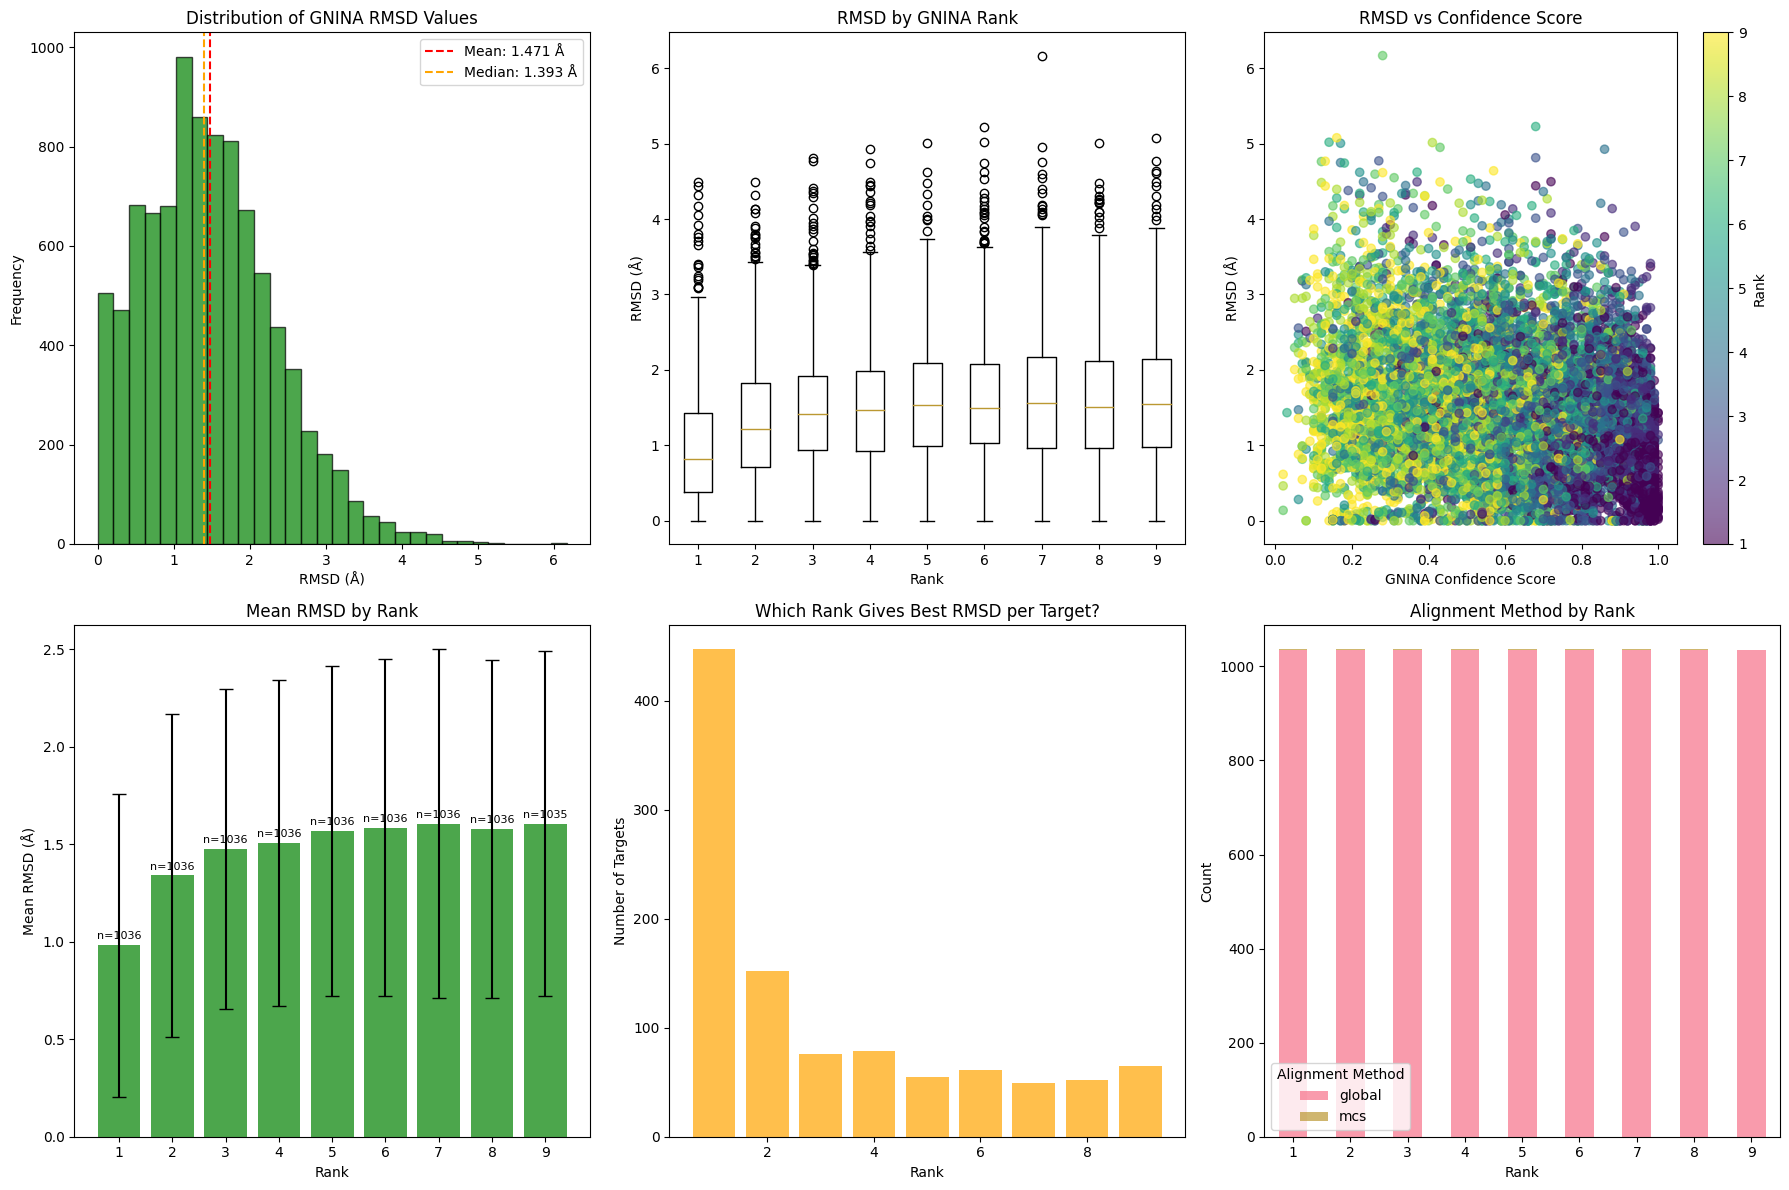


Correlation between rank and RMSD: 0.176
Correlation between confidence score and RMSD: -0.199

Targets where Rank 1 is NOT the best RMSD:
Found 589 targets where rank 1 is not optimal (out of 1036 targets)

Top 10 cases with largest RMSD improvement:
  7m2o__1__1.A__1.B_1.C:
    Rank 1: 3.803 Å (score: 0.72)
    Best (rank 4): 0.606 Å (score: 0.57)
    Improvement: 3.197 Å

  5dw6__1__1.B__1.L:
    Rank 1: 4.496 Å (score: 0.72)
    Best (rank 3): 1.530 Å (score: 0.60)
    Improvement: 2.966 Å

  5odi__1__1.A_1.G__1.N:
    Rank 1: 3.370 Å (score: 0.98)
    Best (rank 2): 0.591 Å (score: 0.97)
    Improvement: 2.779 Å

  2vzq__1__1.A__1.C_1.F:
    Rank 1: 2.860 Å (score: 0.61)
    Best (rank 9): 0.243 Å (score: 0.31)
    Improvement: 2.617 Å

  6wk9__2__1.E_1.F_1.G__1.Q_1.R_1.U_1.V:
    Rank 1: 3.658 Å (score: 0.44)
    Best (rank 2): 1.117 Å (score: 0.33)
    Improvement: 2.541 Å

  5m8m__3__1.C__1.Q:
    Rank 1: 2.771 Å (score: 0.39)
    Best (rank 6): 0.456 Å (score: 0.26)
    Impro

In [29]:
# GNINA Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

if len(gnina_successful_df) > 0:
    # Create comprehensive GNINA visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. RMSD distribution histogram
    axes[0, 0].hist(gnina_successful_df['rmsd'], bins=30, alpha=0.7, edgecolor='black', color='green')
    axes[0, 0].set_xlabel('RMSD (Å)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of GNINA RMSD Values')
    axes[0, 0].axvline(gnina_successful_df['rmsd'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {gnina_successful_df["rmsd"].mean():.3f} Å')
    axes[0, 0].axvline(gnina_successful_df['rmsd'].median(), color='orange', linestyle='--', 
                      label=f'Median: {gnina_successful_df["rmsd"].median():.3f} Å')
    axes[0, 0].legend()
    
    # 2. RMSD by rank (boxplot)
    rank_data = [gnina_successful_df[gnina_successful_df['rank'] == rank]['rmsd'].values 
                 for rank in sorted(gnina_successful_df['rank'].unique())]
    rank_labels = sorted(gnina_successful_df['rank'].unique())
    axes[0, 1].boxplot(rank_data, labels=rank_labels)
    axes[0, 1].set_xlabel('Rank')
    axes[0, 1].set_ylabel('RMSD (Å)')
    axes[0, 1].set_title('RMSD by GNINA Rank')
    
    # 3. RMSD vs Confidence Score
    axes[0, 2].scatter(gnina_successful_df['score'], gnina_successful_df['rmsd'], 
                      c=gnina_successful_df['rank'], cmap='viridis', alpha=0.6)
    axes[0, 2].set_xlabel('GNINA Confidence Score')
    axes[0, 2].set_ylabel('RMSD (Å)')
    axes[0, 2].set_title('RMSD vs Confidence Score')
    cbar = plt.colorbar(axes[0, 2].collections[0], ax=axes[0, 2])
    cbar.set_label('Rank')
    
    # 4. Mean RMSD by rank
    rank_means = gnina_successful_df.groupby('rank')['rmsd'].agg(['mean', 'std', 'count'])
    x_pos = range(len(rank_means))
    axes[1, 0].bar(x_pos, rank_means['mean'], yerr=rank_means['std'], 
                   capsize=5, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Rank')
    axes[1, 0].set_ylabel('Mean RMSD (Å)')
    axes[1, 0].set_title('Mean RMSD by Rank')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(rank_means.index)
    
    # Add count labels on bars
    for i, (mean_val, count) in enumerate(zip(rank_means['mean'], rank_means['count'])):
        axes[1, 0].text(i, mean_val + 0.02, f'n={count}', ha='center', va='bottom', fontsize=8)
    
    # 5. Best rank per target (what rank gives lowest RMSD?)
    target_best_ranks = gnina_successful_df.loc[gnina_successful_df.groupby('target_id')['rmsd'].idxmin()]
    best_rank_counts = target_best_ranks['rank'].value_counts().sort_index()
    axes[1, 1].bar(best_rank_counts.index, best_rank_counts.values, alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Number of Targets')
    axes[1, 1].set_title('Which Rank Gives Best RMSD per Target?')
    
    # 6. Alignment method by rank
    method_by_rank = gnina_successful_df.groupby(['rank', 'alignment_method']).size().unstack(fill_value=0)
    method_by_rank.plot(kind='bar', stacked=True, ax=axes[1, 2], alpha=0.7)
    axes[1, 2].set_xlabel('Rank')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Alignment Method by Rank')
    axes[1, 2].legend(title='Alignment Method')
    axes[1, 2].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

    # Analysis: Correlation between rank and RMSD
    correlation = gnina_successful_df['rank'].corr(gnina_successful_df['rmsd'])
    print(f"\nCorrelation between rank and RMSD: {correlation:.3f}")
    
    # Analysis: Correlation between score and RMSD
    score_correlation = gnina_successful_df['score'].corr(gnina_successful_df['rmsd'])
    print(f"Correlation between confidence score and RMSD: {score_correlation:.3f}")
    
    # Per-target analysis: Show targets where rank 1 is not the best
    print(f"\nTargets where Rank 1 is NOT the best RMSD:")
    print("=" * 60)
    
    target_analysis = []
    for target_id in gnina_successful_df['target_id'].unique():
        target_data = gnina_successful_df[gnina_successful_df['target_id'] == target_id]
        if len(target_data) > 1:  # Only if multiple ranks available
            best_idx = target_data['rmsd'].idxmin()
            best_rank = target_data.loc[best_idx, 'rank']
            best_rmsd = target_data.loc[best_idx, 'rmsd']
            
            # Get rank 1 performance if available
            rank1_data = target_data[target_data['rank'] == 1]
            if len(rank1_data) > 0:
                rank1_rmsd = rank1_data['rmsd'].iloc[0]
                rank1_score = rank1_data['score'].iloc[0]
                best_score = target_data.loc[best_idx, 'score']
                
                target_analysis.append({
                    'target_id': target_id,
                    'best_rank': best_rank,
                    'best_rmsd': best_rmsd,
                    'best_score': best_score,
                    'rank1_rmsd': rank1_rmsd,
                    'rank1_score': rank1_score,
                    'improvement': rank1_rmsd - best_rmsd
                })
    
    # Show cases where rank 1 is not optimal
    suboptimal_rank1 = [t for t in target_analysis if t['best_rank'] != 1]
    suboptimal_rank1.sort(key=lambda x: x['improvement'], reverse=True)  # Largest improvements first
    
    print(f"Found {len(suboptimal_rank1)} targets where rank 1 is not optimal (out of {len(target_analysis)} targets)")
    print("\nTop 10 cases with largest RMSD improvement:")
    for i, target in enumerate(suboptimal_rank1[:10]):
        print(f"  {target['target_id']}:")
        print(f"    Rank 1: {target['rank1_rmsd']:.3f} Å (score: {target['rank1_score']:.2f})")
        print(f"    Best (rank {target['best_rank']}): {target['best_rmsd']:.3f} Å (score: {target['best_score']:.2f})")
        print(f"    Improvement: {target['improvement']:.3f} Å")
        print()

else:
    print("No successful GNINA RMSD computations to visualize.")

In [30]:
# Save GNINA results and compare with Boltz
output_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/"
os.makedirs(output_dir, exist_ok=True)

if len(gnina_successful_df) > 0:
    # Save GNINA detailed results
    gnina_results_file = os.path.join(output_dir, "gnina_comprehensive_rmsd_analysis.csv")
    gnina_df.to_csv(gnina_results_file, index=False)
    print(f"GNINA detailed results saved to: {gnina_results_file}")
    
    # Save GNINA summary statistics
    gnina_summary_stats = {
        'total_pairs': int(len(gnina_df)),
        'successful_pairs': int(len(gnina_successful_df)),
        'failed_pairs': int(len(gnina_df) - len(gnina_successful_df)),
        'unique_targets': int(gnina_df['target_id'].nunique()),
        'mean_rmsd': float(gnina_successful_df['rmsd'].mean()),
        'median_rmsd': float(gnina_successful_df['rmsd'].median()),
        'std_rmsd': float(gnina_successful_df['rmsd'].std()),
        'min_rmsd': float(gnina_successful_df['rmsd'].min()),
        'max_rmsd': float(gnina_successful_df['rmsd'].max()),
        'global_alignments': int((gnina_successful_df['alignment_method'] == 'global').sum()),
        'mcs_alignments': int((gnina_successful_df['alignment_method'] == 'mcs').sum()),
        'rank_correlation': float(gnina_successful_df['rank'].corr(gnina_successful_df['rmsd'])),
        'score_correlation': float(gnina_successful_df['score'].corr(gnina_successful_df['rmsd'])),
    }
    
    gnina_summary_file = os.path.join(output_dir, "gnina_rmsd_summary_stats.json")
    with open(gnina_summary_file, 'w') as f:
        json.dump(gnina_summary_stats, f, indent=2)
    print(f"GNINA summary statistics saved to: {gnina_summary_file}")

    # Compare Boltz vs GNINA performance
    print(f"\n" + "="*80)
    print(f"BOLTZ vs GNINA COMPARISON")
    print(f"="*80)
    
    # Find common targets between Boltz and GNINA
    boltz_targets = set(successful_df['target_id'].unique())
    gnina_targets = set(gnina_successful_df['target_id'].unique())
    common_targets = boltz_targets.intersection(gnina_targets)
    
    print(f"Boltz targets: {len(boltz_targets)}")
    print(f"GNINA targets: {len(gnina_targets)}")
    print(f"Common targets: {len(common_targets)}")
    
    if len(common_targets) > 0:
        # For common targets, compare best performance
        comparison_results = []
        
        for target_id in common_targets:
            # Get best Boltz RMSD for this target
            boltz_target_data = successful_df[successful_df['target_id'] == target_id]
            best_boltz_rmsd = boltz_target_data['rmsd'].min()
            
            # Get best GNINA RMSD for this target (across all ranks)
            gnina_target_data = gnina_successful_df[gnina_successful_df['target_id'] == target_id]
            best_gnina_rmsd = gnina_target_data['rmsd'].min()
            best_gnina_rank = gnina_target_data.loc[gnina_target_data['rmsd'].idxmin(), 'rank']
            
            # Get GNINA rank 1 performance
            gnina_rank1 = gnina_target_data[gnina_target_data['rank'] == 1]
            gnina_rank1_rmsd = gnina_rank1['rmsd'].iloc[0] if len(gnina_rank1) > 0 else None
            
            comparison_results.append({
                'target_id': target_id,
                'boltz_best_rmsd': best_boltz_rmsd,
                'gnina_best_rmsd': best_gnina_rmsd,
                'gnina_best_rank': best_gnina_rank,
                'gnina_rank1_rmsd': gnina_rank1_rmsd,
                'boltz_better': best_boltz_rmsd < best_gnina_rmsd,
                'difference': best_boltz_rmsd - best_gnina_rmsd
            })
        
        comparison_df = pd.DataFrame(comparison_results)
        
        # Overall statistics
        boltz_wins = (comparison_df['boltz_better']).sum()
        gnina_wins = len(comparison_df) - boltz_wins
        
        print(f"\nOverall comparison (best performance per target):")
        print(f"  Boltz better: {boltz_wins} targets ({boltz_wins/len(comparison_df)*100:.1f}%)")
        print(f"  GNINA better: {gnina_wins} targets ({gnina_wins/len(comparison_df)*100:.1f}%)")
        print(f"  Mean RMSD difference (Boltz - GNINA): {comparison_df['difference'].mean():.3f} Å")
        
        # Compare Boltz vs GNINA rank 1 only
        rank1_comparison = comparison_df.dropna(subset=['gnina_rank1_rmsd'])
        boltz_vs_rank1 = (rank1_comparison['boltz_best_rmsd'] < rank1_comparison['gnina_rank1_rmsd']).sum()
        
        print(f"\nBoltz vs GNINA Rank 1 comparison:")
        print(f"  Boltz better than GNINA rank 1: {boltz_vs_rank1} targets ({boltz_vs_rank1/len(rank1_comparison)*100:.1f}%)")
        print(f"  GNINA rank 1 better: {len(rank1_comparison) - boltz_vs_rank1} targets")
        
        # Show some examples
        print(f"\nTop 5 targets where Boltz significantly outperforms GNINA:")
        boltz_advantages = comparison_df[comparison_df['boltz_better']].nlargest(5, 'difference')
        for _, row in boltz_advantages.iterrows():
            print(f"  {row['target_id']}: Boltz {row['boltz_best_rmsd']:.3f} Å vs GNINA {row['gnina_best_rmsd']:.3f} Å (rank {row['gnina_best_rank']}) [Δ: {-row['difference']:.3f} Å]")
        
        print(f"\nTop 5 targets where GNINA significantly outperforms Boltz:")
        gnina_advantages = comparison_df[~comparison_df['boltz_better']].nsmallest(5, 'difference')
        for _, row in gnina_advantages.iterrows():
            print(f"  {row['target_id']}: GNINA {row['gnina_best_rmsd']:.3f} Å (rank {row['gnina_best_rank']}) vs Boltz {row['boltz_best_rmsd']:.3f} Å [Δ: {row['difference']:.3f} Å]")
        
        # Save comparison results
        comparison_file = os.path.join(output_dir, "boltz_vs_gnina_comparison.csv")
        comparison_df.to_csv(comparison_file, index=False)
        print(f"\nComparison results saved to: {comparison_file}")
    
    print(f"\n" + "="*80)
    print(f"GNINA ANALYSIS COMPLETE")
    print(f"="*80)

else:
    print("No successful GNINA RMSD computations found.")

GNINA detailed results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_comprehensive_rmsd_analysis.csv
GNINA summary statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_rmsd_summary_stats.json

BOLTZ vs GNINA COMPARISON
Boltz targets: 955
GNINA targets: 1036
Common targets: 955

Overall comparison (best performance per target):
  Boltz better: 331 targets (34.7%)
  GNINA better: 624 targets (65.3%)
  Mean RMSD difference (Boltz - GNINA): 0.251 Å

Boltz vs GNINA Rank 1 comparison:
  Boltz better than GNINA rank 1: 523 targets (54.8%)
  GNINA rank 1 better: 432 targets

Top 5 targets where Boltz significantly outperforms GNINA:
  7vtf__1__1.A_1.B__1.F: Boltz 0.148 Å vs GNINA 0.148 Å (rank 5) [Δ: 0.000 Å]
  5bs3__1__1.A_1.B__1.I: Boltz 1.269 Å vs GNINA 1.269 Å (rank 7) [Δ: 0.000 Å]
  1u8v__1__1.A_1.B__1.F: Boltz 1.142 Å vs GNINA 1.143 Å (rank 1) [Δ: 0.000 Å]
  6b2a__1__1.A_1.B_1.C__1.I_1

In [31]:
old_df = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv")
num_proteins_below_2 = (old_df.groupby("protein")["ligand_rmsd"].min() < 2).sum()
print(f"Number of proteins with smallest RMSD < 2: {num_proteins_below_2}", num_proteins_below_2 / len(old_df['protein'].unique()))
print(old_df.head())

Number of proteins with smallest RMSD < 2: 887 0.9249217935349322
                 protein  model  confidence  protein_ca_aligned_rmsd  \
0  1afb__1__1.A__1.D_1.F      0    0.968682                 7.288223   
1  1afb__1__1.A__1.D_1.F      1    0.967638                 8.294978   
2  1afb__1__1.A__1.D_1.F      2    0.966930                 7.902068   
3  1b5d__1__1.A_1.B__1.D      0    0.978817                 0.406931   
4  1b5d__1__1.A_1.B__1.D      1    0.978379                 0.379730   

   protein_backbone_aligned_rmsd  ligand_rmsd  ligand_coordinate_rmsd  \
0                       7.234416     0.106312               61.863091   
1                       8.238616     0.113152               53.674979   
2                       7.843212     0.130946               64.802147   
3                       0.415178     0.831780               36.340150   
4                       0.384278     0.520552               25.794543   

   binding_site_aligned_rmsd  atom_count_match  
0            

## Simple and more straightward way to comppute RMSD: 

In [32]:
# Count subdirectories that don't contain the expected prediction files
import glob
import os
pred_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
empty_dirs = []

for sub_dir in os.listdir(pred_base):
    full_path = os.path.join(pred_base, sub_dir)
    if os.path.isdir(full_path):
        # Extract target ID from directory name
        target_id = sub_dir.replace("boltz_results_", "")
        
        # Check for prediction files in the expected nested structure
        predictions_path = os.path.join(full_path, "predictions", target_id)
        
        if os.path.exists(predictions_path) and os.path.isdir(predictions_path):
            # Count ligand prediction files
            ligand_files = glob.glob(os.path.join(predictions_path, "*_ligand_extracted.sdf"))
            print(f"Checking {sub_dir}: {len(ligand_files)} ligand prediction files")
            
            if len(ligand_files) == 0:
                empty_dirs.append(sub_dir)
        else:
            print(f"Checking {sub_dir}: predictions directory not found")
            empty_dirs.append(sub_dir)

print(f"\nNumber of subdirectories without ligand prediction files: {len(empty_dirs)}")
if empty_dirs:
    print("\nDirectories without ligand predictions:")
    for dir_name in empty_dirs[:10]:  # Show first 10
        print(f"  - {dir_name}")
    if len(empty_dirs) > 10:
        print(f"  ... and {len(empty_dirs) - 10} more")

Checking boltz_results_4mws__1__1.A_1.B__1.G: 3 ligand prediction files
Checking boltz_results_4x3l__1__1.A_1.B__1.C: 3 ligand prediction files
Checking boltz_results_4jvo__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_3l4x__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_4s3q__1__1.A__1.D: 3 ligand prediction files
Checking boltz_results_5h41__1__1.A__1.C_1.E_1.F: 3 ligand prediction files
Checking boltz_results_5aog__1__1.A__1.D_1.G_1.H: predictions directory not found
Checking boltz_results_8e0t__1__1.B__1.E: 3 ligand prediction files
Checking boltz_results_7uas__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_4r9j__1__1.A_1.C__1.S: 3 ligand prediction files
Checking boltz_results_3qw7__1__1.A_1.B__1.B_1.C_1.F_1.G: 3 ligand prediction files
Checking boltz_results_5j3z__2__1.B__1.S: 3 ligand prediction files
Checking boltz_results_8f1g__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_6b24__1__1.A_1.B_1.C__1.H: 3 ligand predict

# RMSD for other approaches 

In [ ]:
# Get current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

# Navigate up to the notebooks root directory
notebooks_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
print("Notebooks root:", notebooks_root)

# Build correct utils path
utils_path = os.path.join(notebooks_root, '04_utils')
print("Utils path:", utils_path)

# Verify the path exists
print("Path exists:", os.path.exists(utils_path))
print("Approach.py exists:", os.path.exists(os.path.join(utils_path, 'Approach.py')))

# Add to Python path
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

# Now try importing
try:
    from Approach import DockingApproach, ICMApproach, ChaiApproach, VinaApproach, GninaApproach, SurfDockApproach, DiffDockPocketApproach, DiffDockApproach
    print("✅ Successfully imported all approaches!")
except ImportError as e:
    print(f"❌ Import failed: {e}")

Current directory: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/01_method_analysis/boltz/development
Notebooks root: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks
Utils path: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/04_utils
Path exists: True
Approach.py exists: True
✅ Successfully imported all approaches!
✅ Successfully imported all approaches!


## compute

In [35]:
def load_first_mol(sdf_file):
    """Return the first molecule in an SDF (with hydrogens removed)."""
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    if not suppl or suppl[0] is None:
        raise ValueError(f"Could not read a molecule from {sdf_file}")
    return Chem.RemoveHs(suppl[0])

def compute_rmsd_on_mcs(ref_path, pred_path):
    ref_mol = load_first_mol(ref_path)
    pred_mol = load_first_mol(pred_path)
    
    # Try global alignment first
    try:
        rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
        method = "global"
        n_atoms = ref_mol.GetNumAtoms()
        return rmsd
    except RuntimeError:
        # Fall back to MCS if global alignment fails
        rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
        method = "mcs"
        return None

def compute_rmsd_for_all_methods(
    approach: DockingApproach,
    base_outdir: str,
    data_dir: str,
    top_n: int = 5,
    docking: bool = False,
) -> pd.DataFrame:
    """
    For each protein subdir in base_outdir:
      - list up to top_n SDF files (method-specific naming)
      - run PoseBusters on each
      - parse a numeric score or confidence if available
      - collect results in a DataFrame
    """
    method_name = approach.get_name()
    all_rows = []

    for protein_name in tqdm(os.listdir(data_dir)):
        try: 
            if "plinder" in data_dir:
                # protein_dir = glob.glob(f"{base_outdir}/*{protein_name.replace('.','_')}*")[0] ## for ICM specific
                protein_dir = glob.glob(f"{base_outdir}/*{protein_name}*")[0]
            else:
                protein_dir = glob.glob(f"{base_outdir}/*{protein_name}*")[0]
        # protein_dir = os.path.join(base_outdir, protein_name)
        except: 
            print(f"Could not find {protein_name} in {base_outdir}")
            continue
        if not os.path.isdir(protein_dir):
            continue

        # Retrieve up to top-N .sdf file paths
        sdf_paths = approach.list_top_n_files(protein_dir, top_n)
        if not sdf_paths:
            print(f"[{method_name}] No top-{top_n} SDF files found for {protein_name}")
            continue

        # References
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        if not (os.path.isfile(true_ligand) and os.path.isfile(protein_pdb)):
            print(f"[{method_name}] Missing reference for {protein_name}")
            continue

        rank_counter = 1
        for sdf_path in sdf_paths:
            try:
                # parse numeric score or confidence if available
                numeric_score = approach.parse_score(sdf_path)
                rmsd = compute_rmsd_on_mcs(
                    true_ligand, sdf_path
                )

                # Create a single-row DataFrame from a dictionary
                df_pb = pd.DataFrame([{
                    "rmsd": rmsd,
                    "score": numeric_score,
                    "method": method_name,
                    "protein": protein_name,
                    "rank": rank_counter
                }])
                
                rank_counter += 1
                all_rows.append(df_pb)
            except Exception as e:
                print(f"[{method_name}] [ERROR] PoseBusters failed for {protein_name}: {e}")

    if not all_rows:
        return pd.DataFrame()
    return pd.concat(all_rows, ignore_index=True)

# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"

exp_name = "plinder_set_0"

# Initialize your approaches
approaches = [
    # ICMApproach(),
    # DiffDockApproach(),
    SurfDockApproach(),
    # DiffDockPocketApproach(), 
    GninaApproach(), 
    ChaiApproach(),
    # VinaApproach()
    # BoltzApproach(),
    # ... add more if needed
]

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/plinder_set_0",
    # "diffdock": f"{base_outdir}/DiffDock/inference/diffdock_plinder_benchmark_output_0",
    "diffdock_pocket_only": f"{base_outdir}/DiffDock/inference/diffdock_pocket_only_plinder_benchmark_output_1",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_plinder_outputs_0",
    # "vina": f"{base_outdir}/Vina/inference/GNINA_plinder_output_0", 
    "gnina":f"{base_outdir}/GNINA/inference/GNINA_plinder_output_0",
    "surfdock":f"{base_outdir}/SurfDock/inference/SurfDock_plinder_set_1",
    # "boltz": f"{base_outdir}/boltz/inference/{exp_name}",
    # ...
}

# The folder containing the real (crystal) ligand and protein PDB:
#  PoseBench/data/posebusters_benchmark_set/<protein>/
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"


df_all = []

for approach in approaches:
    method_name = approach.get_name()
    base_outdir = BASE_DIRS[method_name]
    df_method = compute_rmsd_for_all_methods(
        approach,
        base_outdir=base_outdir,
        data_dir=DATA_DIR,
        top_n=5
    )
    df_all.append(df_method)
    df_method.to_csv(f"../../../06_results_archive/{method_name}_{exp_name}_rmsd.csv", index=False)
df_combined = pd.concat(df_all, ignore_index=True)
print(df_combined.shape)
df_combined.head()

  1%|          | 10/1037 [00:00<00:11, 91.59it/s]

Parsed from 1r34_1.D_1r34__1__1.A__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_1_rmsd_1.6537988443439229_confidence_137.53929345991443.sdf: RMSD=1.6537988443439229, confidence=137.53929345991443
Parsed from 1r34_1.D_1r34__1__1.A__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_2_rmsd_1.4777774670481378_confidence_123.7984021011349.sdf: RMSD=1.4777774670481378, confidence=123.7984021011349
Parsed from 1r34_1.D_1r34__1__1.A__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_23_rank_3_rmsd_1.6666948134080772_confidence_111.24283873436292.sdf: RMSD=1.6666948134080772, confidence=111.24283873436292
Parsed from 1r34_1.D_1r34__1__1.A__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_4_rmsd_1.1616575991749818_confidence_106.84647208023814.sdf: RMSD=1.1616575991749818, confidence=106.84647208023814
Parsed from 1r34_1.D_1r34__1__1.A__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_13_rank_5_rmsd_1.1774744958221695_confidence_105.01793401354745.sdf: RMSD=1.1774744958221695, co

  3%|▎         | 35/1037 [00:00<00:09, 110.34it/s]

Parsed from 3lgm_1.C_3lgm__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_5_rmsd_1.796856975970621_confidence_171.19371869618763.sdf: RMSD=1.796856975970621, confidence=171.19371869618763
Parsed from 7siy_1.B_7siy__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_1_rmsd_1.1248585367479318_confidence_237.6864434994852.sdf: RMSD=1.1248585367479318, confidence=237.6864434994852
Parsed from 7siy_1.B_7siy__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_2_rmsd_1.0708141206568331_confidence_208.29041680230995.sdf: RMSD=1.0708141206568331, confidence=208.29041680230995
Parsed from 7siy_1.B_7siy__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_3_rmsd_1.1110216989274273_confidence_200.90995090379923.sdf: RMSD=1.1110216989274273, confidence=200.90995090379923
Parsed from 7siy_1.B_7siy__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_27_rank_4_rmsd_1.742808988794654_confidence_194.13513071837662.sdf: RMSD=1.742808988794654, confidence=194.1351307183766

  6%|▌         | 60/1037 [00:00<00:08, 118.37it/s]

Parsed from 3nqm_1.C_3nqm__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_34_rank_1_rmsd_0.6429945056559206_confidence_417.1766258727387.sdf: RMSD=0.6429945056559206, confidence=417.1766258727387
Parsed from 3nqm_1.C_3nqm__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_2_rmsd_0.6065085784785168_confidence_415.0094560835071.sdf: RMSD=0.6065085784785168, confidence=415.0094560835071
Parsed from 3nqm_1.C_3nqm__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_10_rank_3_rmsd_0.6366329941702799_confidence_411.6479291056692.sdf: RMSD=0.6366329941702799, confidence=411.6479291056692
Parsed from 3nqm_1.C_3nqm__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_27_rank_4_rmsd_0.6682253925420378_confidence_406.67624284624117.sdf: RMSD=0.6682253925420378, confidence=406.67624284624117
Parsed from 3nqm_1.C_3nqm__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_5_rmsd_1.8213802156234127_confidence_402.89668138580777.sdf: RMSD=1.8213802156234127, confide

  8%|▊         | 85/1037 [00:00<00:08, 116.50it/s]

Parsed from 2o6p_1.F_2o6p__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_3_rank_1_rmsd_6.362098696746544_confidence_148.01476663739808.sdf: RMSD=6.362098696746544, confidence=148.01476663739808
Parsed from 2o6p_1.F_2o6p__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_2_rmsd_1.4754126639502458_confidence_147.73050795694994.sdf: RMSD=1.4754126639502458, confidence=147.73050795694994
Parsed from 2o6p_1.F_2o6p__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_3_rmsd_6.2063670594644975_confidence_140.25771660928544.sdf: RMSD=6.2063670594644975, confidence=140.25771660928544
Parsed from 2o6p_1.F_2o6p__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_4_rmsd_1.5298748608495965_confidence_135.82254768251457.sdf: RMSD=1.5298748608495965, confidence=135.82254768251457
Parsed from 2o6p_1.F_2o6p__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_5_rmsd_6.944918950759986_confidence_134.2788711447013.sdf: RMSD=6.944918950759986, confidence=134.2788711447013

 11%|█         | 110/1037 [00:00<00:08, 110.19it/s]

Parsed from 5lx6_1.C_5lx6__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_1_rmsd_0.7418805664333759_confidence_197.9692560394129.sdf: RMSD=0.7418805664333759, confidence=197.9692560394129
Parsed from 5lx6_1.C_5lx6__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_18_rank_2_rmsd_0.6289377899165473_confidence_192.05563909618007.sdf: RMSD=0.6289377899165473, confidence=192.05563909618007
Parsed from 5lx6_1.C_5lx6__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_3_rmsd_0.7674401423471919_confidence_184.91666517569487.sdf: RMSD=0.7674401423471919, confidence=184.91666517569487
Parsed from 5lx6_1.C_5lx6__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_4_rmsd_1.2940074705013762_confidence_184.361386694723.sdf: RMSD=1.2940074705013762, confidence=184.361386694723
Parsed from 5lx6_1.C_5lx6__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_5_rmsd_0.8268503127676556_confidence_182.3735101807834.sdf: RMSD=0.8268503127676556, confidence=182.3735101807834

 13%|█▎        | 136/1037 [00:01<00:07, 114.72it/s]

Parsed from 2r1r_1.G_2r1r__1__1.A__1.G_ligand.sdf_file_inner_idx_0_sample_idx_25_rank_3_rmsd_7.4324624684945615_confidence_39.76341243135966.sdf: RMSD=7.4324624684945615, confidence=39.76341243135966
Parsed from 2r1r_1.G_2r1r__1__1.A__1.G_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_4_rmsd_6.679554504717081_confidence_35.851752752229054.sdf: RMSD=6.679554504717081, confidence=35.851752752229054
Parsed from 2r1r_1.G_2r1r__1__1.A__1.G_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_5_rmsd_7.960223618165049_confidence_33.73522870096943.sdf: RMSD=7.960223618165049, confidence=33.73522870096943
Parsed from 6r4g_1.F_6r4g__1__1.B__1.F_1.G_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_1_rmsd_3.7292832601769375_confidence_214.43001997257937.sdf: RMSD=3.7292832601769375, confidence=214.43001997257937
Parsed from 6r4g_1.F_6r4g__1__1.B__1.F_1.G_ligand.sdf_file_inner_idx_0_sample_idx_35_rank_2_rmsd_2.4679897489479807_confidence_185.34504557254334.sdf: RMSD=2.4679897489479807, confidence=185.34504

 16%|█▌        | 162/1037 [00:01<00:07, 119.26it/s]

Parsed from 8k5y_1.H_8k5y__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_1_rmsd_1.6507645153074992_confidence_104.68039625040645.sdf: RMSD=1.6507645153074992, confidence=104.68039625040645
Parsed from 8k5y_1.H_8k5y__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_2_rmsd_8.800434640625047_confidence_84.39334124128384.sdf: RMSD=8.800434640625047, confidence=84.39334124128384
Parsed from 8k5y_1.H_8k5y__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_3_rmsd_8.828089414715016_confidence_82.8171145218469.sdf: RMSD=8.828089414715016, confidence=82.8171145218469
Parsed from 8k5y_1.H_8k5y__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_11_rank_4_rmsd_8.809434073229829_confidence_79.57282952633498.sdf: RMSD=8.809434073229829, confidence=79.57282952633498
Parsed from 8k5y_1.H_8k5y__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_29_rank_5_rmsd_8.877899046866222_confidence_75.38445889556148.sdf: RMSD=8.877899046866222, confidence=75.38445889556148
Parsed f

 18%|█▊        | 187/1037 [00:01<00:07, 119.68it/s]

Parsed from 3inb_1.F_3inb__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_1_rmsd_2.6397268845489568_confidence_54.02421820248784.sdf: RMSD=2.6397268845489568, confidence=54.02421820248784
Parsed from 3inb_1.F_3inb__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_2_rmsd_2.609288975550815_confidence_52.8881590070706.sdf: RMSD=2.609288975550815, confidence=52.8881590070706
Parsed from 3inb_1.F_3inb__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_3_rmsd_1.3858547358567124_confidence_43.15567968235634.sdf: RMSD=1.3858547358567124, confidence=43.15567968235634
Parsed from 3inb_1.F_3inb__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_29_rank_4_rmsd_1.5660383327807768_confidence_42.184477932952866.sdf: RMSD=1.5660383327807768, confidence=42.184477932952866
Parsed from 3inb_1.F_3inb__1__1.A__1.F_ligand.sdf_file_inner_idx_0_sample_idx_23_rank_5_rmsd_1.2401856399071907_confidence_41.07141125120084.sdf: RMSD=1.2401856399071907, confidence=41.07141125120084
Pa

 21%|██        | 213/1037 [00:01<00:06, 122.45it/s]

Parsed from 1wk9_1.B_1wk9__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_35_rank_4_rmsd_1.6095816914561218_confidence_138.05630504995938.sdf: RMSD=1.6095816914561218, confidence=138.05630504995938
Parsed from 1wk9_1.B_1wk9__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_5_rmsd_1.066158283543498_confidence_134.50838587229745.sdf: RMSD=1.066158283543498, confidence=134.50838587229745
Parsed from 6bkz_1.D_6bkz__1__1.A_1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_1_rmsd_1.0549351495085197_confidence_247.4429130737861.sdf: RMSD=1.0549351495085197, confidence=247.4429130737861
Parsed from 6bkz_1.D_6bkz__1__1.A_1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_2_rmsd_1.069151440230069_confidence_222.6012770946386.sdf: RMSD=1.069151440230069, confidence=222.6012770946386
Parsed from 6bkz_1.D_6bkz__1__1.A_1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_3_rmsd_0.9571300190969668_confidence_208.7728094611186.sdf: RMSD=0.9571300190969668, confidence=208.772

 23%|██▎       | 240/1037 [00:02<00:06, 127.51it/s]

Parsed from 3ej2_3.B_3ej2__1__3.A_4.A__3.B_4.B_ligand.sdf_file_inner_idx_0_sample_idx_10_rank_1_rmsd_0.3441961489069002_confidence_132.63301171202747.sdf: RMSD=0.3441961489069002, confidence=132.63301171202747
Parsed from 3ej2_3.B_3ej2__1__3.A_4.A__3.B_4.B_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_2_rmsd_0.27546288329963986_confidence_124.99677341013216.sdf: RMSD=0.27546288329963986, confidence=124.99677341013216
Parsed from 3ej2_3.B_3ej2__1__3.A_4.A__3.B_4.B_ligand.sdf_file_inner_idx_0_sample_idx_18_rank_3_rmsd_0.27006541629990466_confidence_124.30477090372338.sdf: RMSD=0.27006541629990466, confidence=124.30477090372338
Parsed from 3ej2_3.B_3ej2__1__3.A_4.A__3.B_4.B_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_4_rmsd_0.6309793718035402_confidence_117.3264421690646.sdf: RMSD=0.6309793718035402, confidence=117.3264421690646
Parsed from 3ej2_3.B_3ej2__1__3.A_4.A__3.B_4.B_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_5_rmsd_0.38960330529058573_confidence_116.13332111107428.sdf: RMS

 24%|██▍       | 253/1037 [00:02<00:06, 122.15it/s]

Parsed from 7vjt_1.C_7vjt__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_2_rmsd_0.7359147744562866_confidence_412.4495260350122.sdf: RMSD=0.7359147744562866, confidence=412.4495260350122
Parsed from 7vjt_1.C_7vjt__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_3_rmsd_0.499397865889324_confidence_408.1050663063315.sdf: RMSD=0.499397865889324, confidence=408.1050663063315
Parsed from 7vjt_1.C_7vjt__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_24_rank_4_rmsd_0.4258785334371822_confidence_406.0589694745471.sdf: RMSD=0.4258785334371822, confidence=406.0589694745471
Parsed from 7vjt_1.C_7vjt__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_5_rmsd_0.5471077749673132_confidence_405.31404473331867.sdf: RMSD=0.5471077749673132, confidence=405.31404473331867
Parsed from 5ylt_1.C_5ylt__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_1_rmsd_0.5312556885875422_confidence_240.90553922635416.sdf: RMSD=0.5312556885875422, confidence=240.9055392263541

 27%|██▋       | 280/1037 [00:02<00:06, 125.81it/s]

Parsed from 5jmy_1.N_5jmy__2__1.B__1.M_1.N_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_5_rmsd_0.9740585174047414_confidence_328.61299948343617.sdf: RMSD=0.9740585174047414, confidence=328.61299948343617
Parsed from 3bkq_1.B_3bkq__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_1_rmsd_0.44490128479975777_confidence_168.77515593409026.sdf: RMSD=0.44490128479975777, confidence=168.77515593409026
Parsed from 3bkq_1.B_3bkq__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_2_rmsd_0.4950040892490868_confidence_156.08107182305886.sdf: RMSD=0.4950040892490868, confidence=156.08107182305886
Parsed from 3bkq_1.B_3bkq__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_3_rmsd_0.6655396328841776_confidence_152.81384742582765.sdf: RMSD=0.6655396328841776, confidence=152.81384742582765
Parsed from 3bkq_1.B_3bkq__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_4_rmsd_0.5254477148357485_confidence_152.52145983556716.sdf: RMSD=0.5254477148357485, confidence=152.521

 30%|██▉       | 308/1037 [00:02<00:05, 129.98it/s]

Parsed from 4u2y_1.D_4u2y__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_18_rank_3_rmsd_0.9644032024807517_confidence_170.21481909319297.sdf: RMSD=0.9644032024807517, confidence=170.21481909319297
Parsed from 4u2y_1.D_4u2y__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_4_rmsd_0.9122536228859052_confidence_165.41471804495265.sdf: RMSD=0.9122536228859052, confidence=165.41471804495265
Parsed from 4u2y_1.D_4u2y__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_5_rmsd_1.04061915813277_confidence_162.74852051731347.sdf: RMSD=1.04061915813277, confidence=162.74852051731347
Parsed from 1l4y_1.H_1l4y__1__1.A__1.B_1.H_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_1_rmsd_0.7862072684057357_confidence_355.60151197107695.sdf: RMSD=0.7862072684057357, confidence=355.60151197107695
Parsed from 1l4y_1.H_1l4y__1__1.A__1.B_1.H_ligand.sdf_file_inner_idx_0_sample_idx_23_rank_2_rmsd_0.8724241719392158_confidence_328.236821941545.sdf: RMSD=0.8724241719392158, confidence=328.236

 32%|███▏      | 335/1037 [00:02<00:05, 126.00it/s]

Parsed from 5v3x_1.C_5v3x__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_2_rmsd_0.49392013792547457_confidence_470.68746931781976.sdf: RMSD=0.49392013792547457, confidence=470.68746931781976
Parsed from 5v3x_1.C_5v3x__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_3_rmsd_0.7160888327966257_confidence_441.8253424249109.sdf: RMSD=0.7160888327966257, confidence=441.8253424249109
Parsed from 5v3x_1.C_5v3x__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_4_rmsd_0.5237828737215932_confidence_437.22874417516346.sdf: RMSD=0.5237828737215932, confidence=437.22874417516346
Parsed from 5v3x_1.C_5v3x__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_5_rmsd_0.5409422944360887_confidence_436.60336020520924.sdf: RMSD=0.5409422944360887, confidence=436.60336020520924
Parsed from 1rlz_3.B_1rlz__1__1.A_2.A_3.A_4.A__2.B_3.B_ligand.sdf_file_inner_idx_0_sample_idx_38_rank_1_rmsd_1.1698142695263212_confidence_493.9610585097324.sdf: RMSD=1.1698142695263212, confi

 35%|███▍      | 361/1037 [00:03<00:05, 121.83it/s]

Parsed from 6oa1_1.B_6oa1__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_2_rmsd_2.31794143878748_confidence_192.23018862993635.sdf: RMSD=2.31794143878748, confidence=192.23018862993635
Parsed from 6oa1_1.B_6oa1__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_3_rmsd_0.9083218288135344_confidence_190.1365325863092.sdf: RMSD=0.9083218288135344, confidence=190.1365325863092
Parsed from 6oa1_1.B_6oa1__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_4_rmsd_3.2960223179200705_confidence_174.31000109301254.sdf: RMSD=3.2960223179200705, confidence=174.31000109301254
Parsed from 6oa1_1.B_6oa1__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_5_rmsd_0.642039328127329_confidence_168.49743064113042.sdf: RMSD=0.642039328127329, confidence=168.49743064113042
Parsed from 3p5p_1.E_3p5p__1__1.A__1.B_1.C_1.E_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_1_rmsd_2.0905915866754343_confidence_125.60288904567757.sdf: RMSD=2.0905915866754343, confidence=125.6028890

 37%|███▋      | 388/1037 [00:03<00:05, 126.85it/s]

Parsed from 4gc4_1.D_4gc4__1__1.A_1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_5_rmsd_0.713935383834297_confidence_328.199047679028.sdf: RMSD=0.713935383834297, confidence=328.199047679028
Parsed from 5qpg_2.H_5qpg__1__2.A__2.H_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_1_rmsd_0.6294268935892448_confidence_194.64697232270134.sdf: RMSD=0.6294268935892448, confidence=194.64697232270134
Parsed from 5qpg_2.H_5qpg__1__2.A__2.H_ligand.sdf_file_inner_idx_0_sample_idx_34_rank_2_rmsd_0.5650433720745693_confidence_186.58552169026675.sdf: RMSD=0.5650433720745693, confidence=186.58552169026675
Parsed from 5qpg_2.H_5qpg__1__2.A__2.H_ligand.sdf_file_inner_idx_0_sample_idx_11_rank_3_rmsd_0.9262665861550331_confidence_184.643145178728.sdf: RMSD=0.9262665861550331, confidence=184.643145178728
Parsed from 5qpg_2.H_5qpg__1__2.A__2.H_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_4_rmsd_0.4973091103878252_confidence_182.135686712183.sdf: RMSD=0.4973091103878252, confidence=182.135686712183
Pa

 40%|████      | 415/1037 [00:03<00:05, 122.57it/s]

Parsed from 1w2x_2.D_1w2x__1__1.A_2.A__2.D_ligand.sdf_file_inner_idx_0_sample_idx_25_rank_1_rmsd_9.545281004439572_confidence_81.63775482318312.sdf: RMSD=9.545281004439572, confidence=81.63775482318312
Parsed from 1w2x_2.D_1w2x__1__1.A_2.A__2.D_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_2_rmsd_9.204611740043823_confidence_72.39266307749912.sdf: RMSD=9.204611740043823, confidence=72.39266307749912
Parsed from 1w2x_2.D_1w2x__1__1.A_2.A__2.D_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_3_rmsd_9.382743543743098_confidence_70.71986574069163.sdf: RMSD=9.382743543743098, confidence=70.71986574069163
Parsed from 1w2x_2.D_1w2x__1__1.A_2.A__2.D_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_4_rmsd_9.1577856526738_confidence_69.5963324202652.sdf: RMSD=9.1577856526738, confidence=69.5963324202652
Parsed from 1w2x_2.D_1w2x__1__1.A_2.A__2.D_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_5_rmsd_9.476536042010697_confidence_69.23122744103476.sdf: RMSD=9.476536042010697, confidence=69.2312274410347

 43%|████▎     | 442/1037 [00:03<00:04, 120.64it/s]

Parsed from 7vtf_1.F_7vtf__1__1.A_1.B__1.F_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_2_rmsd_0.4883604215720903_confidence_213.7037282825981.sdf: RMSD=0.4883604215720903, confidence=213.7037282825981
Parsed from 7vtf_1.F_7vtf__1__1.A_1.B__1.F_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_3_rmsd_0.5322933108165495_confidence_211.91121330815687.sdf: RMSD=0.5322933108165495, confidence=211.91121330815687
Parsed from 7vtf_1.F_7vtf__1__1.A_1.B__1.F_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_4_rmsd_0.4267205198549319_confidence_207.79046251704645.sdf: RMSD=0.4267205198549319, confidence=207.79046251704645
Parsed from 7vtf_1.F_7vtf__1__1.A_1.B__1.F_ligand.sdf_file_inner_idx_0_sample_idx_38_rank_5_rmsd_0.37107348471480106_confidence_199.48885964388418.sdf: RMSD=0.37107348471480106, confidence=199.48885964388418
Parsed from 5h42_1.C_5h42__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_1_rmsd_0.844576318094805_confidence_136.2332258891663.sdf: RMSD=0.844576318094805, confidenc

 44%|████▍     | 456/1037 [00:03<00:04, 123.99it/s]

Parsed from 7nag_1.D_7nag__2__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_3_rmsd_2.9384485524296147_confidence_69.814304265132.sdf: RMSD=2.9384485524296147, confidence=69.814304265132
Parsed from 7nag_1.D_7nag__2__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_4_rmsd_9.873323874872497_confidence_69.37474546753333.sdf: RMSD=9.873323874872497, confidence=69.37474546753333
Parsed from 7nag_1.D_7nag__2__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_5_rmsd_7.731999065691493_confidence_67.61937286168411.sdf: RMSD=7.731999065691493, confidence=67.61937286168411
Parsed from 3wsx_1.C_3wsx__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_29_rank_1_rmsd_2.3612318851718306_confidence_64.52603363560357.sdf: RMSD=2.3612318851718306, confidence=64.52603363560357
Parsed from 3wsx_1.C_3wsx__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_2_rmsd_2.3225849356747412_confidence_55.70035787052626.sdf: RMSD=2.3225849356747412, confidence=55.70035787052626
Parsed fr

 46%|████▋     | 481/1037 [00:04<00:05, 103.14it/s]

Parsed from 4tsq_1.U_4tsq__3__1.C__1.U_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_4_rmsd_5.828225708912709_confidence_78.61589051024403.sdf: RMSD=5.828225708912709, confidence=78.61589051024403
Parsed from 4tsq_1.U_4tsq__3__1.C__1.U_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_5_rmsd_5.714798704620374_confidence_75.71941518602867.sdf: RMSD=5.714798704620374, confidence=75.71941518602867
Parsed from 4i4v_1.L_4i4v__2__1.D__1.L_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_1_rmsd_1.0378148071309088_confidence_94.20374307021395.sdf: RMSD=1.0378148071309088, confidence=94.20374307021395
Parsed from 4i4v_1.L_4i4v__2__1.D__1.L_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_2_rmsd_1.3437619102866278_confidence_90.34860953374974.sdf: RMSD=1.3437619102866278, confidence=90.34860953374974
Parsed from 4i4v_1.L_4i4v__2__1.D__1.L_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_3_rmsd_1.014021170595315_confidence_83.60383085829876.sdf: RMSD=1.014021170595315, confidence=83.60383085829876
Parsed

 49%|████▊     | 505/1037 [00:04<00:04, 108.66it/s]

Parsed from 4zmm_1.D_4zmm__1__1.A_1.B__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_4_rmsd_3.0831055066963615_confidence_78.9776094814453.sdf: RMSD=3.0831055066963615, confidence=78.9776094814453
Parsed from 4zmm_1.D_4zmm__1__1.A_1.B__1.C_1.D_ligand.sdf_file_inner_idx_0_sample_idx_37_rank_5_rmsd_3.2621089537880583_confidence_74.39182683330998.sdf: RMSD=3.2621089537880583, confidence=74.39182683330998
Parsed from 3e08_1.R_3e08__1__1.A_1.B_1.D__1.R_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_1_rmsd_0.49148864209813237_confidence_207.59805892345153.sdf: RMSD=0.49148864209813237, confidence=207.59805892345153
Parsed from 3e08_1.R_3e08__1__1.A_1.B_1.D__1.R_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_2_rmsd_0.3449450742035877_confidence_193.7655934484972.sdf: RMSD=0.3449450742035877, confidence=193.7655934484972
Parsed from 3e08_1.R_3e08__1__1.A_1.B_1.D__1.R_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_3_rmsd_0.5528099076356732_confidence_166.78882851594213.sdf: RMSD=0.552809

 51%|█████     | 529/1037 [00:04<00:04, 110.05it/s]

Parsed from 8e1s_1.C_8e1s__1__1.A__1.C_1.E_1.F_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_5_rmsd_1.3561811193355457_confidence_345.28866075509063.sdf: RMSD=1.3561811193355457, confidence=345.28866075509063
Parsed from 3nqd_1.C_3nqd__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_1_rmsd_0.5570019529658946_confidence_437.8566687823966.sdf: RMSD=0.5570019529658946, confidence=437.8566687823966
Parsed from 3nqd_1.C_3nqd__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_2_rmsd_0.5555357719863976_confidence_437.5015398074019.sdf: RMSD=0.5555357719863976, confidence=437.5015398074019
Parsed from 3nqd_1.C_3nqd__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_3_rmsd_0.6269266734807073_confidence_434.001549024372.sdf: RMSD=0.6269266734807073, confidence=434.001549024372
Parsed from 3nqd_1.C_3nqd__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_4_rmsd_0.5983686516028961_confidence_409.68757994791855.sdf: RMSD=0.5983686516028961, confi

 52%|█████▏    | 541/1037 [00:04<00:04, 112.64it/s]

Parsed from 4o3f_1.B_4o3f__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_4_rmsd_1.0030302589878626_confidence_297.49051632997833.sdf: RMSD=1.0030302589878626, confidence=297.49051632997833
Parsed from 4o3f_1.B_4o3f__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_5_rmsd_0.6379789734673179_confidence_296.3590897714707.sdf: RMSD=0.6379789734673179, confidence=296.3590897714707
Parsed from 6bto_1.F_6bto__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_1_rmsd_1.1835034649245555_confidence_287.233817361773.sdf: RMSD=1.1835034649245555, confidence=287.233817361773
Parsed from 6bto_1.F_6bto__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_2_rmsd_0.9044681490846059_confidence_266.83686330567895.sdf: RMSD=0.9044681490846059, confidence=266.83686330567895
Parsed from 6bto_1.F_6bto__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_38_rank_3_rmsd_1.0794525155806336_confidence_258.0728953898415.sdf: RMSD=1.0794525155806336, confidence=258.07

 54%|█████▍    | 564/1037 [00:04<00:04, 102.80it/s]

Parsed from 1los_1.E_1los__1__1.A_1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_2_rmsd_0.6012740757828837_confidence_310.11473488271525.sdf: RMSD=0.6012740757828837, confidence=310.11473488271525
Parsed from 1los_1.E_1los__1__1.A_1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_3_rmsd_0.5400792283016531_confidence_308.3309919744671.sdf: RMSD=0.5400792283016531, confidence=308.3309919744671
Parsed from 1los_1.E_1los__1__1.A_1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_4_rmsd_0.5251663289099116_confidence_307.0530467818376.sdf: RMSD=0.5251663289099116, confidence=307.0530467818376
Parsed from 1los_1.E_1los__1__1.A_1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_5_rmsd_0.5739203553877085_confidence_302.5029357788002.sdf: RMSD=0.5739203553877085, confidence=302.5029357788002
Parsed from 5hmw_1.D_5hmw__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_1_rmsd_0.5726237426733976_confidence_288.52436668126046.sdf: RMSD=0.5726237426733976, confidence=2

 56%|█████▌    | 577/1037 [00:04<00:04, 109.21it/s][01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 14 15
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 14 25
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 15 16
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 1 2
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 2 3
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 1 2
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 2 3
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 14 15
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 14 25
[01:00:03] Both bonds on one end of an atropisomer are on the same side - atoms are: 15 16
[01:00:03] 

****
Post-condition Violation
Elem

Parsed from 6wo4_1.E_6wo4__1__1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_1_rmsd_2.880916886767234_confidence_44.57193833494637.sdf: RMSD=2.880916886767234, confidence=44.57193833494637
Parsed from 6wo4_1.E_6wo4__1__1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_2_rmsd_7.375725029099006_confidence_27.878192496483507.sdf: RMSD=7.375725029099006, confidence=27.878192496483507
Parsed from 6wo4_1.E_6wo4__1__1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_3_rmsd_7.455485636830164_confidence_27.520995311283432.sdf: RMSD=7.455485636830164, confidence=27.520995311283432
Parsed from 6wo4_1.E_6wo4__1__1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_4_rmsd_7.491624838638229_confidence_25.965557294174758.sdf: RMSD=7.491624838638229, confidence=25.965557294174758
Parsed from 6wo4_1.E_6wo4__1__1.B__1.E_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_5_rmsd_7.68826701271745_confidence_24.53649441769644.sdf: RMSD=7.68826701271745, confidence=24.53649441769644
Parsed

 59%|█████▉    | 612/1037 [00:05<00:04, 103.57it/s]

Parsed from 8wsm_1.D_8wsm__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_3_rmsd_1.3564049062603718_confidence_190.12144070515726.sdf: RMSD=1.3564049062603718, confidence=190.12144070515726
Parsed from 8wsm_1.D_8wsm__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_4_rmsd_1.350498929947116_confidence_166.4066459057828.sdf: RMSD=1.350498929947116, confidence=166.4066459057828
Parsed from 8wsm_1.D_8wsm__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_18_rank_5_rmsd_3.2785998124584212_confidence_161.7841154506726.sdf: RMSD=3.2785998124584212, confidence=161.7841154506726
Parsed from 6tez_1.C_6tez__1__1.A__1.C_1.I_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_1_rmsd_1.5396835379868132_confidence_231.1318047844828.sdf: RMSD=1.5396835379868132, confidence=231.1318047844828
Parsed from 6tez_1.C_6tez__1__1.A__1.C_1.I_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_2_rmsd_2.4557191605249953_confidence_190.80541452864705.sdf: RMSD=2.4557191605249953, confidence=190.80541

 60%|██████    | 624/1037 [00:05<00:03, 107.32it/s]

Parsed from 1j1m_1.B_1j1m__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_3_rmsd_1.6215359105116653_confidence_59.864319676954736.sdf: RMSD=1.6215359105116653, confidence=59.864319676954736
Parsed from 1j1m_1.B_1j1m__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_4_rmsd_1.7937828483854632_confidence_58.067949208831706.sdf: RMSD=1.7937828483854632, confidence=58.067949208831706
Parsed from 1j1m_1.B_1j1m__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_5_rmsd_3.2741190136983636_confidence_57.853621469939476.sdf: RMSD=3.2741190136983636, confidence=57.853621469939476
Parsed from 8b0d_1.C_8b0d__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_1_rmsd_0.6504245487444015_confidence_266.6026562391864.sdf: RMSD=0.6504245487444015, confidence=266.6026562391864
Parsed from 8b0d_1.C_8b0d__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_2_rmsd_0.7762701829239396_confidence_260.07963479361285.sdf: RMSD=0.7762701829239396, confidence=260.079634793

 62%|██████▏   | 648/1037 [00:05<00:03, 105.42it/s]

Parsed from 6el3_1.G_6el3__3__1.A__1.G_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_4_rmsd_1.888552906712504_confidence_321.6235814909573.sdf: RMSD=1.888552906712504, confidence=321.6235814909573
Parsed from 6el3_1.G_6el3__3__1.A__1.G_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_5_rmsd_1.3953517604930967_confidence_319.3738482508857.sdf: RMSD=1.3953517604930967, confidence=319.3738482508857
Parsed from 4x97_1.H_4x97__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_1_rmsd_1.4938678201645976_confidence_54.41065502622747.sdf: RMSD=1.4938678201645976, confidence=54.41065502622747
Parsed from 4x97_1.H_4x97__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_2_rmsd_4.975093934045756_confidence_52.53757488201772.sdf: RMSD=4.975093934045756, confidence=52.53757488201772
Parsed from 4x97_1.H_4x97__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_3_rmsd_5.056748722779836_confidence_48.12552830441227.sdf: RMSD=5.056748722779836, confidence=48.12552830441227
Parsed f

 65%|██████▍   | 673/1037 [00:11<00:36,  9.87it/s] 

Parsed from 1wda_2.J_1wda__1__2.A__2.J_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_1_rmsd_0.9819530214825324_confidence_212.6829228189647.sdf: RMSD=0.9819530214825324, confidence=212.6829228189647
Parsed from 1wda_2.J_1wda__1__2.A__2.J_ligand.sdf_file_inner_idx_0_sample_idx_29_rank_2_rmsd_0.9085297718513613_confidence_210.89913391229268.sdf: RMSD=0.9085297718513613, confidence=210.89913391229268
Parsed from 1wda_2.J_1wda__1__2.A__2.J_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_3_rmsd_0.9357703664419548_confidence_210.37811433414382.sdf: RMSD=0.9357703664419548, confidence=210.37811433414382
Parsed from 1wda_2.J_1wda__1__2.A__2.J_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_4_rmsd_1.1852238303191107_confidence_200.14329991273834.sdf: RMSD=1.1852238303191107, confidence=200.14329991273834
Parsed from 1wda_2.J_1wda__1__2.A__2.J_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_5_rmsd_1.3643459428786657_confidence_195.95200562520134.sdf: RMSD=1.3643459428786657, confidence=195.952005625

 67%|██████▋   | 697/1037 [00:11<00:18, 17.90it/s]

Parsed from 4xp1_1.N_4xp1__1__1.A__1.N_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_2_rmsd_3.2025373027769963_confidence_18.517840326875522.sdf: RMSD=3.2025373027769963, confidence=18.517840326875522
Parsed from 4xp1_1.N_4xp1__1__1.A__1.N_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_3_rmsd_2.3741517481739107_confidence_17.43497741765592.sdf: RMSD=2.3741517481739107, confidence=17.43497741765592
Parsed from 4xp1_1.N_4xp1__1__1.A__1.N_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_4_rmsd_2.321156156005447_confidence_16.345751591355906.sdf: RMSD=2.321156156005447, confidence=16.345751591355906
Parsed from 4xp1_1.N_4xp1__1__1.A__1.N_ligand.sdf_file_inner_idx_0_sample_idx_25_rank_5_rmsd_3.436811560951835_confidence_15.480503054538246.sdf: RMSD=3.436811560951835, confidence=15.480503054538246
Parsed from 4glx_1.G_4glx__1__1.D__1.G_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_1_rmsd_0.1819610306624624_confidence_449.55330369278045.sdf: RMSD=0.1819610306624624, confidence=449.553303692780

 70%|██████▉   | 721/1037 [00:11<00:10, 31.32it/s]

Parsed from 5m77_1.D_5m77__2__1.B__1.D_1.R_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_1_rmsd_1.4849115020419648_confidence_145.83600210876955.sdf: RMSD=1.4849115020419648, confidence=145.83600210876955
Parsed from 5m77_1.D_5m77__2__1.B__1.D_1.R_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_2_rmsd_2.4168749744739717_confidence_144.32148311965156.sdf: RMSD=2.4168749744739717, confidence=144.32148311965156
Parsed from 5m77_1.D_5m77__2__1.B__1.D_1.R_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_3_rmsd_1.6664274546786548_confidence_129.76514986072598.sdf: RMSD=1.6664274546786548, confidence=129.76514986072598
Parsed from 5m77_1.D_5m77__2__1.B__1.D_1.R_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_4_rmsd_1.5861591376227213_confidence_128.4029501175527.sdf: RMSD=1.5861591376227213, confidence=128.4029501175527
Parsed from 5m77_1.D_5m77__2__1.B__1.D_1.R_ligand.sdf_file_inner_idx_0_sample_idx_37_rank_5_rmsd_1.4425353432284822_confidence_126.22476283955535.sdf: RMSD=1.4425353432284822, conf

 72%|███████▏  | 743/1037 [00:11<00:06, 47.26it/s]

Parsed from 6r4j_1.G_6r4j__1__1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_1_rmsd_2.0948941559025287_confidence_223.6011212278851.sdf: RMSD=2.0948941559025287, confidence=223.6011212278851
Parsed from 6r4j_1.G_6r4j__1__1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_37_rank_2_rmsd_3.2867808633611344_confidence_205.6195542175438.sdf: RMSD=3.2867808633611344, confidence=205.6195542175438
Parsed from 6r4j_1.G_6r4j__1__1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_3_rmsd_3.0150058119227148_confidence_205.2224644646476.sdf: RMSD=3.0150058119227148, confidence=205.2224644646476
Parsed from 6r4j_1.G_6r4j__1__1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_4_rmsd_3.5399942685681722_confidence_195.50078176745066.sdf: RMSD=3.5399942685681722, confidence=195.50078176745066
Parsed from 6r4j_1.G_6r4j__1__1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_5_rmsd_2.8176634034030017_confidence_189.18161139102682.sdf: RMSD=2.8176634034030017, confide

 73%|███████▎  | 754/1037 [00:12<00:05, 54.88it/s]

Parsed from 4ad4_1.B_4ad4__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_5_rmsd_1.7333691697674394_confidence_44.14713359245511.sdf: RMSD=1.7333691697674394, confidence=44.14713359245511
Parsed from 3b03_1.E_3b03__1__1.A__1.E_1.F_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_1_rmsd_1.325504090919276_confidence_253.68071350019602.sdf: RMSD=1.325504090919276, confidence=253.68071350019602
Parsed from 3b03_1.E_3b03__1__1.A__1.E_1.F_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_2_rmsd_1.877571313303359_confidence_206.5607215579937.sdf: RMSD=1.877571313303359, confidence=206.5607215579937
Parsed from 3b03_1.E_3b03__1__1.A__1.E_1.F_ligand.sdf_file_inner_idx_0_sample_idx_24_rank_3_rmsd_1.202689495997652_confidence_190.7981108830645.sdf: RMSD=1.202689495997652, confidence=190.7981108830645
Parsed from 3b03_1.E_3b03__1__1.A__1.E_1.F_ligand.sdf_file_inner_idx_0_sample_idx_13_rank_4_rmsd_1.8582962581111913_confidence_184.18252501211916.sdf: RMSD=1.8582962581111913, confidence=184.1

 75%|███████▍  | 775/1037 [00:12<00:04, 61.91it/s]

Parsed from 4mwf_1.L_4mwf__2__1.C__1.L_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_1_rmsd_1.5121436447720973_confidence_60.67031678735341.sdf: RMSD=1.5121436447720973, confidence=60.67031678735341
Parsed from 4mwf_1.L_4mwf__2__1.C__1.L_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_2_rmsd_5.13913080803151_confidence_52.462134964585246.sdf: RMSD=5.13913080803151, confidence=52.462134964585246
Parsed from 4mwf_1.L_4mwf__2__1.C__1.L_ligand.sdf_file_inner_idx_0_sample_idx_6_rank_3_rmsd_1.5525505092464709_confidence_51.03018952849073.sdf: RMSD=1.5525505092464709, confidence=51.03018952849073
Parsed from 4mwf_1.L_4mwf__2__1.C__1.L_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_4_rmsd_5.1111343847573245_confidence_46.82037570947432.sdf: RMSD=5.1111343847573245, confidence=46.82037570947432
Parsed from 4mwf_1.L_4mwf__2__1.C__1.L_ligand.sdf_file_inner_idx_0_sample_idx_24_rank_5_rmsd_5.116156740601038_confidence_45.78979836510929.sdf: RMSD=5.116156740601038, confidence=45.78979836510929
Parsed

 77%|███████▋  | 794/1037 [00:12<00:03, 72.34it/s]

Parsed from 5svl_3.T_5svl__2__3.B__3.T_ligand.sdf_file_inner_idx_0_sample_idx_11_rank_5_rmsd_5.270760624436162_confidence_24.007734125905014.sdf: RMSD=5.270760624436162, confidence=24.007734125905014
Parsed from 6cq8_1.H_6cq8__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_29_rank_1_rmsd_1.1506444545527557_confidence_267.79791416571067.sdf: RMSD=1.1506444545527557, confidence=267.79791416571067
Parsed from 6cq8_1.H_6cq8__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_2_rmsd_1.1990689452079952_confidence_250.35531405985876.sdf: RMSD=1.1990689452079952, confidence=250.35531405985876
Parsed from 6cq8_1.H_6cq8__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_3_rmsd_1.0359080693695308_confidence_236.2254845910613.sdf: RMSD=1.0359080693695308, confidence=236.2254845910613
Parsed from 6cq8_1.H_6cq8__1__1.A__1.H_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_4_rmsd_1.119144512282564_confidence_234.32777109697616.sdf: RMSD=1.119144512282564, confidence=234.327771096976

 77%|███████▋  | 803/1037 [00:12<00:03, 76.26it/s]

Parsed from 1w2c_1.H_1w2c__2__1.B__1.H_1.I_1.J_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_1_rmsd_1.6484924048279408_confidence_87.26417277418226.sdf: RMSD=1.6484924048279408, confidence=87.26417277418226
Parsed from 1w2c_1.H_1w2c__2__1.B__1.H_1.I_1.J_ligand.sdf_file_inner_idx_0_sample_idx_34_rank_2_rmsd_1.309898706493833_confidence_72.36218535019609.sdf: RMSD=1.309898706493833, confidence=72.36218535019609
Parsed from 1w2c_1.H_1w2c__2__1.B__1.H_1.I_1.J_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_3_rmsd_1.3811698040927403_confidence_71.26293570854197.sdf: RMSD=1.3811698040927403, confidence=71.26293570854197
Parsed from 1w2c_1.H_1w2c__2__1.B__1.H_1.I_1.J_ligand.sdf_file_inner_idx_0_sample_idx_7_rank_4_rmsd_1.6387094049341848_confidence_65.3838713412742.sdf: RMSD=1.6387094049341848, confidence=65.3838713412742
Parsed from 1w2c_1.H_1w2c__2__1.B__1.H_1.I_1.J_ligand.sdf_file_inner_idx_0_sample_idx_25_rank_5_rmsd_1.5488791674899973_confidence_59.306188713894755.sdf: RMSD=1.54887916748

 79%|███████▉  | 824/1037 [00:12<00:02, 83.47it/s]

Parsed from 6gbx_1.F_6gbx__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_24_rank_3_rmsd_1.8080039512906314_confidence_180.49686768445332.sdf: RMSD=1.8080039512906314, confidence=180.49686768445332
Parsed from 6gbx_1.F_6gbx__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_4_rmsd_1.101791439242106_confidence_180.18804548204136.sdf: RMSD=1.101791439242106, confidence=180.18804548204136
Parsed from 6gbx_1.F_6gbx__1__1.A__1.D_1.F_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_5_rmsd_1.0525509025131643_confidence_179.68937367211174.sdf: RMSD=1.0525509025131643, confidence=179.68937367211174
Parsed from 5wdl_1.V_5wdl__1__1.F__1.V_ligand.sdf_file_inner_idx_0_sample_idx_34_rank_1_rmsd_1.3818085511671825_confidence_171.68176930514656.sdf: RMSD=1.3818085511671825, confidence=171.68176930514656
Parsed from 5wdl_1.V_5wdl__1__1.F__1.V_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_2_rmsd_1.5005429744665173_confidence_169.87128088153813.sdf: RMSD=1.5005429744665173, confidence=

 82%|████████▏ | 846/1037 [00:13<00:02, 88.59it/s]

Parsed from 3lty_1.C_3lty__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_2_rmsd_0.6787204836684789_confidence_428.6949576848175.sdf: RMSD=0.6787204836684789, confidence=428.6949576848175
Parsed from 3lty_1.C_3lty__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_3_rmsd_0.6442621643214409_confidence_426.0058346685179.sdf: RMSD=0.6442621643214409, confidence=426.0058346685179
Parsed from 3lty_1.C_3lty__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_4_rmsd_0.6626097896410887_confidence_421.54848814087813.sdf: RMSD=0.6626097896410887, confidence=421.54848814087813
Parsed from 3lty_1.C_3lty__1__1.A_1.B__1.C_ligand.sdf_file_inner_idx_0_sample_idx_2_rank_5_rmsd_0.7086318574227398_confidence_412.6715527372266.sdf: RMSD=0.7086318574227398, confidence=412.6715527372266
Parsed from 1u8v_1.F_1u8v__1__1.A_1.B__1.F_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_1_rmsd_1.7245880892610652_confidence_185.26448467832213.sdf: RMSD=1.7245880892610652, confiden

 84%|████████▎ | 867/1037 [00:13<00:01, 90.51it/s]

Parsed from 1tcc_1.C_1tcc__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_2_rmsd_7.158086937275873_confidence_39.65323324798549.sdf: RMSD=7.158086937275873, confidence=39.65323324798549
Parsed from 1tcc_1.C_1tcc__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_3_rmsd_7.103345103032928_confidence_39.54248937605406.sdf: RMSD=7.103345103032928, confidence=39.54248937605406
Parsed from 1tcc_1.C_1tcc__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_4_rmsd_6.9856076628142_confidence_39.019331738786065.sdf: RMSD=6.9856076628142, confidence=39.019331738786065
Parsed from 1tcc_1.C_1tcc__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_21_rank_5_rmsd_6.97322426817803_confidence_38.76491657707772.sdf: RMSD=6.97322426817803, confidence=38.76491657707772
Parsed from 4hb0_1.F_4hb0__1__1.C__1.F_ligand.sdf_file_inner_idx_0_sample_idx_30_rank_1_rmsd_2.0320069827259037_confidence_98.63297027362674.sdf: RMSD=2.0320069827259037, confidence=98.63297027362674
Parsed from 

 85%|████████▍ | 877/1037 [00:13<00:01, 88.88it/s]

Parsed from 6wia_2.C_6wia__1__2.A__2.C_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_1_rmsd_6.835148707725143_confidence_22.6314759803168.sdf: RMSD=6.835148707725143, confidence=22.6314759803168
Parsed from 6wia_2.C_6wia__1__2.A__2.C_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_2_rmsd_7.026634285041301_confidence_21.97344377033809.sdf: RMSD=7.026634285041301, confidence=21.97344377033809
Parsed from 6wia_2.C_6wia__1__2.A__2.C_ligand.sdf_file_inner_idx_0_sample_idx_27_rank_3_rmsd_6.043946213299512_confidence_21.135265144821314.sdf: RMSD=6.043946213299512, confidence=21.135265144821314
Parsed from 6wia_2.C_6wia__1__2.A__2.C_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_4_rmsd_6.095563378375193_confidence_20.41673659165453.sdf: RMSD=6.095563378375193, confidence=20.41673659165453
Parsed from 6wia_2.C_6wia__1__2.A__2.C_ligand.sdf_file_inner_idx_0_sample_idx_3_rank_5_rmsd_7.059191056938818_confidence_19.81254255243498.sdf: RMSD=7.059191056938818, confidence=19.81254255243498
Parsed from 

 86%|████████▋ | 896/1037 [00:13<00:01, 82.11it/s]

Parsed from 1g60_1.D_1g60__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_1_rmsd_1.1288877413286924_confidence_419.4514921308442.sdf: RMSD=1.1288877413286924, confidence=419.4514921308442
Parsed from 1g60_1.D_1g60__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_11_rank_2_rmsd_0.7899258118765669_confidence_412.43051401399646.sdf: RMSD=0.7899258118765669, confidence=412.43051401399646
Parsed from 1g60_1.D_1g60__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_25_rank_3_rmsd_1.5014770872735324_confidence_371.467251418482.sdf: RMSD=1.5014770872735324, confidence=371.467251418482
Parsed from 1g60_1.D_1g60__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_4_rmsd_1.2780058884210208_confidence_342.9546119999332.sdf: RMSD=1.2780058884210208, confidence=342.9546119999332
Parsed from 1g60_1.D_1g60__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_5_rmsd_0.8932674533724977_confidence_338.0692514688771.sdf: RMSD=0.8932674533724977, confidence=338.0692514688771
P

 88%|████████▊ | 917/1037 [00:13<00:01, 80.96it/s]

Parsed from 4cyj_1.G_4cyj__1__1.A__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_1_rmsd_1.5837825825215757_confidence_378.22285960832136.sdf: RMSD=1.5837825825215757, confidence=378.22285960832136
Parsed from 4cyj_1.G_4cyj__1__1.A__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_2_rmsd_1.6324009896200766_confidence_362.2490901685318.sdf: RMSD=1.6324009896200766, confidence=362.2490901685318
Parsed from 4cyj_1.G_4cyj__1__1.A__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_3_rmsd_1.7266770690035873_confidence_356.1570465966912.sdf: RMSD=1.7266770690035873, confidence=356.1570465966912
Parsed from 4cyj_1.G_4cyj__1__1.A__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_4_rmsd_1.3708412527807394_confidence_320.3162932429752.sdf: RMSD=1.3708412527807394, confidence=320.3162932429752
Parsed from 4cyj_1.G_4cyj__1__1.A__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_28_rank_5_rmsd_1.5704323974425891_confidence_311.00919718499205.sdf: RMSD=1.5704323974425891, confiden

 90%|█████████ | 935/1037 [00:14<00:01, 83.35it/s]

Parsed from 1h79_2.B_1h79__1__1.A_2.A__2.B_2.C_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_3_rmsd_1.0455191897121277_confidence_228.40223060029584.sdf: RMSD=1.0455191897121277, confidence=228.40223060029584
Parsed from 1h79_2.B_1h79__1__1.A_2.A__2.B_2.C_ligand.sdf_file_inner_idx_0_sample_idx_22_rank_4_rmsd_1.0257774071299093_confidence_226.17244969518342.sdf: RMSD=1.0257774071299093, confidence=226.17244969518342
Parsed from 1h79_2.B_1h79__1__1.A_2.A__2.B_2.C_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_5_rmsd_1.0050405823340023_confidence_221.77654119567708.sdf: RMSD=1.0050405823340023, confidence=221.77654119567708
Parsed from 1z70_1.B_1z70__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_1_rmsd_7.678613924167921_confidence_32.75850298204559.sdf: RMSD=7.678613924167921, confidence=32.75850298204559
Parsed from 1z70_1.B_1z70__1__1.A__1.B_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_2_rmsd_6.828183295245364_confidence_28.51585858166583.sdf: RMSD=6.828183295245364, conf

 91%|█████████ | 944/1037 [00:14<00:01, 83.90it/s]

Parsed from 4jvo_1.C_4jvo__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_27_rank_1_rmsd_1.1388694647992212_confidence_121.81310655288775.sdf: RMSD=1.1388694647992212, confidence=121.81310655288775
Parsed from 4jvo_1.C_4jvo__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_2_rmsd_1.0355467496045778_confidence_113.80903358098342.sdf: RMSD=1.0355467496045778, confidence=113.80903358098342
Parsed from 4jvo_1.C_4jvo__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_10_rank_3_rmsd_0.8167723395422243_confidence_110.86108597329363.sdf: RMSD=0.8167723395422243, confidence=110.86108597329363
Parsed from 4jvo_1.C_4jvo__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_4_rmsd_1.2510313225354288_confidence_101.26953804021113.sdf: RMSD=1.2510313225354288, confidence=101.26953804021113
Parsed from 4jvo_1.C_4jvo__1__1.A__1.C_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_5_rmsd_0.9034066025230018_confidence_100.11860019890895.sdf: RMSD=0.9034066025230018, confidence=100.1186001

 93%|█████████▎| 962/1037 [00:14<00:00, 80.54it/s]

Parsed from 5xmp_1.H_5xmp__1__1.A_1.B__1.G_1.H_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_5_rmsd_1.2547726512039474_confidence_212.59179338086616.sdf: RMSD=1.2547726512039474, confidence=212.59179338086616
Parsed from 7vf3_1.G_7vf3__2__1.C__1.G_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_1_rmsd_1.510857818372394_confidence_70.27082444748554.sdf: RMSD=1.510857818372394, confidence=70.27082444748554
Parsed from 7vf3_1.G_7vf3__2__1.C__1.G_ligand.sdf_file_inner_idx_0_sample_idx_3_rank_2_rmsd_1.5157615618236122_confidence_51.774585081397916.sdf: RMSD=1.5157615618236122, confidence=51.774585081397916
Parsed from 7vf3_1.G_7vf3__2__1.C__1.G_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_3_rmsd_5.043107121359934_confidence_48.31580250886296.sdf: RMSD=5.043107121359934, confidence=48.31580250886296
Parsed from 7vf3_1.G_7vf3__2__1.C__1.G_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_4_rmsd_1.7192688289178106_confidence_46.28951727520774.sdf: RMSD=1.7192688289178106, confidence=46.289517275

 95%|█████████▍| 984/1037 [00:14<00:00, 89.10it/s]

Parsed from 1ofd_1.C_1ofd__1__1.A__1.C_1.E_ligand.sdf_file_inner_idx_0_sample_idx_1_rank_2_rmsd_0.6771577657075972_confidence_338.4606265456921.sdf: RMSD=0.6771577657075972, confidence=338.4606265456921
Parsed from 1ofd_1.C_1ofd__1__1.A__1.C_1.E_ligand.sdf_file_inner_idx_0_sample_idx_13_rank_3_rmsd_0.625153958967284_confidence_333.0450835515699.sdf: RMSD=0.625153958967284, confidence=333.0450835515699
Parsed from 1ofd_1.C_1ofd__1__1.A__1.C_1.E_ligand.sdf_file_inner_idx_0_sample_idx_19_rank_4_rmsd_1.0029499015553502_confidence_318.8983530364618.sdf: RMSD=1.0029499015553502, confidence=318.8983530364618
Parsed from 1ofd_1.C_1ofd__1__1.A__1.C_1.E_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_5_rmsd_1.1093184149569477_confidence_314.7116371805342.sdf: RMSD=1.1093184149569477, confidence=314.7116371805342
Parsed from 5bzl_1.D_5bzl__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_4_rank_1_rmsd_1.0664193614382629_confidence_111.3268018948525.sdf: RMSD=1.0664193614382629, confidence=111.32

 97%|█████████▋| 1006/1037 [00:14<00:00, 95.06it/s]

Parsed from 6sh1_1.D_6sh1__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_1_rmsd_5.280432640455369_confidence_33.1403027713317.sdf: RMSD=5.280432640455369, confidence=33.1403027713317
Parsed from 6sh1_1.D_6sh1__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_37_rank_2_rmsd_2.7288402451409923_confidence_32.920448306454524.sdf: RMSD=2.7288402451409923, confidence=32.920448306454524
Parsed from 6sh1_1.D_6sh1__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_39_rank_3_rmsd_5.400255594327881_confidence_32.71405070274032.sdf: RMSD=5.400255594327881, confidence=32.71405070274032
Parsed from 6sh1_1.D_6sh1__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_10_rank_4_rmsd_1.835065466737186_confidence_30.639640225268998.sdf: RMSD=1.835065466737186, confidence=30.639640225268998
Parsed from 6sh1_1.D_6sh1__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_5_rmsd_5.127773273233046_confidence_30.26094554911072.sdf: RMSD=5.127773273233046, confidence=30.26094554911072
Parsed 

 98%|█████████▊| 1016/1037 [00:15<00:00, 80.29it/s]

Parsed from 4kax_1.H_4kax__1__1.B__1.H_ligand.sdf_file_inner_idx_0_sample_idx_2_rank_3_rmsd_0.9156567971931616_confidence_228.2523737456019.sdf: RMSD=0.9156567971931616, confidence=228.2523737456019
Parsed from 4kax_1.H_4kax__1__1.B__1.H_ligand.sdf_file_inner_idx_0_sample_idx_12_rank_4_rmsd_0.8177311494259982_confidence_227.58458371264996.sdf: RMSD=0.8177311494259982, confidence=227.58458371264996
Parsed from 4kax_1.H_4kax__1__1.B__1.H_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_5_rmsd_0.9418231522936502_confidence_225.1847504242511.sdf: RMSD=0.9418231522936502, confidence=225.1847504242511
Parsed from 1xuo_1.D_1xuo__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_1_rmsd_1.3545404440759474_confidence_157.98245483535314.sdf: RMSD=1.3545404440759474, confidence=157.98245483535314
Parsed from 1xuo_1.D_1xuo__1__1.A__1.D_ligand.sdf_file_inner_idx_0_sample_idx_18_rank_2_rmsd_1.3457084513255457_confidence_140.94413525572432.sdf: RMSD=1.3457084513255457, confidence=140.94413525572

100%|██████████| 1037/1037 [00:15<00:00, 67.45it/s]

Parsed from 5y4z_1.B_5y4z__1__1.A__1.B_1.C_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_4_rmsd_1.0898219931052546_confidence_181.68820111532483.sdf: RMSD=1.0898219931052546, confidence=181.68820111532483
Parsed from 5y4z_1.B_5y4z__1__1.A__1.B_1.C_ligand.sdf_file_inner_idx_0_sample_idx_26_rank_5_rmsd_0.9352308311170215_confidence_158.12685546786716.sdf: RMSD=0.9352308311170215, confidence=158.12685546786716
Parsed from 1isf_1.D_1isf__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_34_rank_1_rmsd_7.279639428349114_confidence_58.98156129337612.sdf: RMSD=7.279639428349114, confidence=58.98156129337612
Parsed from 1isf_1.D_1isf__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_8_rank_2_rmsd_6.98361189039925_confidence_55.16568227510638.sdf: RMSD=6.98361189039925, confidence=55.16568227510638
Parsed from 1isf_1.D_1isf__1__1.B__1.D_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_3_rmsd_7.103379409128367_confidence_53.740308966871034.sdf: RMSD=7.103379409128367, confidence=53.74030896687


 18%|█▊        | 182/1037 [00:01<00:05, 145.20it/s]

Could not find .DS_Store in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/GNINA/inference/GNINA_plinder_output_0


100%|██████████| 1037/1037 [00:14<00:00, 72.70it/s] 

  1%|▏         | 14/1037 [00:00<00:07, 133.53it/s]

Could not find 1r34__1__1.A__1.C_1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 7li5__1__1.A__1.C
Could not find 1siw__1__1.B_1.C__1.L in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5qgm__1__1.A__1.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 3lgm__1__1.A__1.C


  5%|▌         | 54/1037 [00:00<00:10, 98.06it/s] 

[chai-1] No top-5 SDF files found for 3ayf__1__1.A__1.B_1.C_1.E
Could not find 2pnc__1__1.B__1.O in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 3ek5__1__1.A_1.C_1.D_1.E_1.F__1.K_1.L in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5my0__2__1.D__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


  9%|▉         | 91/1037 [00:00<00:09, 103.78it/s]

[chai-1] No top-5 SDF files found for 2o6p__1__1.A__1.F
[chai-1] No top-5 SDF files found for 3w8o__2__1.B__1.D


 11%|█         | 113/1037 [00:01<00:09, 93.08it/s]

[chai-1] No top-5 SDF files found for 2bs3__1__1.C_1.E_1.F__1.V_1.W
Could not find 4zdk__1__1.B_3.A__3.D_3.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 4usc__1__1.B__1.V


 13%|█▎        | 138/1037 [00:01<00:09, 98.42it/s] 

Could not find 3tz3__1__1.A_2.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 4l1r__2__1.B_3.B__1.K in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1zef__1__2.A__2.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 3ju4__1__1.A_2.A_3.A__1.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6rms__1__1.A_2.A__2.E_2.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 16%|█▌        | 165/1037 [00:01<00:08, 100.63it/s]

Could not find 6uux__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find .DS_Store in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 18%|█▊        | 187/1037 [00:01<00:08, 96.46it/s] 

Could not find 8p0m__1__1.C__1.L in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 23%|██▎       | 237/1037 [00:02<00:06, 116.08it/s]

[chai-1] No top-5 SDF files found for 5o0t__1__1.A__1.F
Could not find 1n2k__1__2.A__2.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 25%|██▌       | 260/1037 [00:02<00:07, 101.78it/s]

Could not find 4a1o__1__1.A_1.B__1.E_1.I in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 4hsi__2__1.B_2.B__2.K in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 5aog__1__1.A__1.D_1.G_1.H
Could not find 5h41__1__1.A__1.C_1.E_1.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 3bkq__1__1.A__1.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1gm9__1__1.A_1.B__1.M_1.O in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 28%|██▊       | 290/1037 [00:02<00:06, 109.76it/s]

Could not find 4rvh__1__1.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 4agi__1__1.C__1.W in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 31%|███▏      | 326/1037 [00:03<00:06, 107.07it/s]

Could not find 5uy8__1__1.A_1.B__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 8gm5__1__1.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1rlz__1__1.A_2.A_3.A_4.A__2.B_3.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1h7a__1__1.A_2.A__2.B_2.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 34%|███▎      | 348/1037 [00:03<00:07, 90.86it/s] 

Could not find 1d7d__1__1.A_1.B__1.E_1.L in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5qha__1__1.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 35%|███▍      | 358/1037 [00:03<00:07, 91.36it/s]

Could not find 7e8q__1__1.A_1.C_1.D__1.J in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 5ohf__3__1.E_1.F__1.T_1.U


 41%|████      | 424/1037 [00:04<00:04, 129.00it/s]

Could not find 2pnc__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1w2x__1__1.A_2.A__2.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 7vzn__1__1.A_1.B__1.S_1.T_1.U in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6f83__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5h42__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 43%|████▎     | 451/1037 [00:04<00:05, 111.03it/s]

Could not find 2uag__1__1.A__1.B_1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 2cix__1__1.A__1.E_1.F_1.S in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5cdo__1__1.A_1.C_1.D__1.W in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6cin__2__1.D__1.CA_1.DA in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 45%|████▍     | 463/1037 [00:04<00:05, 110.01it/s]

[chai-1] No top-5 SDF files found for 5oef__2__1.B__1.K_1.L
[chai-1] No top-5 SDF files found for 2bs2__1__1.C_1.E_1.F__1.V_1.W
Could not find 5odi__1__1.A_1.G__1.N in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 47%|████▋     | 486/1037 [00:04<00:05, 101.38it/s]

Could not find 1oa2__3__1.C__1.I in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6tsr__1__2.A__2.B_2.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1us1__1__1.B__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 52%|█████▏    | 539/1037 [00:05<00:04, 117.85it/s]

Could not find 3nwd__3__1.C_3.C__3.O in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 6yf4__1__1.A__1.C_1.D
Could not find 6lel__1__1.A_2.B__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5yij__1__1.A_1.C__1.E in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 58%|█████▊    | 598/1037 [00:05<00:03, 128.97it/s]

Could not find 1thz__1__1.A_1.B__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 7nim__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 2uue__2__1.D_1.F__1.F_1.J in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 6f1q__1__1.A_3.A__3.D
Could not find 5wgt__2__1.A_2.A__1.O in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 60%|██████    | 625/1037 [00:05<00:03, 114.92it/s]

Could not find 8ogh__1__1.A_1.B__1.M_1.R in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1q16__1__1.B_1.C__1.N in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 2gag__1__1.A_1.B__1.H_1.J in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 63%|██████▎   | 649/1037 [00:06<00:03, 102.43it/s]

Could not find 6el3__3__1.A__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1qwu__1__1.A__1.C_1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 64%|██████▍   | 668/1037 [00:12<00:44,  8.32it/s] 

Could not find 6lq9__1__1.C__1.J in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6yh0__1__1.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 66%|██████▋   | 688/1037 [00:12<00:23, 14.78it/s]

Could not find 4v59__1__1.E__1.Q in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 69%|██████▉   | 718/1037 [00:12<00:10, 31.48it/s]

Could not find 4cmm__1__1.B__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 3lgn__1__1.A__1.C_1.D
Could not find 8hx7__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 71%|███████▏  | 741/1037 [00:13<00:05, 49.85it/s]

[chai-1] No top-5 SDF files found for 5bys__1__1.A__1.C_1.H
Could not find 4hjh__2__1.B__1.IC in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 3vph__1__1.A_1.B_1.C_1.D__1.F_1.H_1.Q in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 6apw__1__1.A__1.B
Could not find 8cb6__1__1.B__1.E in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 74%|███████▍  | 770/1037 [00:13<00:03, 78.18it/s]

Could not find 8hq3__1__1.C__1.JA in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5o22__1__1.A__1.E in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 5m92__1__1.A__1.D_1.E_1.N
[chai-1] No top-5 SDF files found for 3ayg__2__2.A__2.B_2.C_2.E


 77%|███████▋  | 796/1037 [00:13<00:03, 74.25it/s]

Could not find 2aph__3__2.B_2.D__2.D_2.H in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 8fvb__1__1.B_2.A_2.B__2.E in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 7ygg__2__1.D__1.I in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 79%|███████▉  | 820/1037 [00:13<00:02, 89.70it/s]

Could not find 7pxn__1__1.A__1.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 2cvc__1__1.A__1.L
Could not find 1kv3__2__1.B_1.F__1.L in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 4hat__1__1.C__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6dft__2__1.E_1.F_1.G_1.H__1.T_1.U in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1u8v__1__1.A_1.B__1.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 82%|████████▏ | 850/1037 [00:14<00:01, 108.28it/s]

[chai-1] No top-5 SDF files found for 6qpv__2__1.B_3.B__3.H
[chai-1] No top-5 SDF files found for 7w81__1__1.A_1.B__1.C_1.D
Could not find 5bs3__1__1.A_1.B__1.I in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 4hb0__1__1.C__1.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 8gen__1__2.A_3.A__2.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 85%|████████▍ | 878/1037 [00:14<00:01, 109.11it/s]

Could not find 6cip__2__1.D__1.CA_1.DA in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 6wia__1__2.A__2.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 8bzx__1__1.A_1.B__1.C_1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 89%|████████▊ | 920/1037 [00:14<00:00, 119.74it/s]

Could not find 2xpc__1__1.A__1.B_1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 3e4w__2__1.B__1.J_1.L_1.M
Could not find 1h8v__1__1.A__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 5uz0__1__1.A_1.B__1.F in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
[chai-1] No top-5 SDF files found for 3ocd__1__1.A__1.E
Could not find 1h79__1__1.A_2.A__2.B_2.C in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1z70__1__1.A__1.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 90%|████████▉ | 933/1037 [00:14<00:00, 114.60it/s]

Could not find 4wy0__1__1.F_1.K__1.DA in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 92%|█████████▏| 956/1037 [00:15<00:00, 95.01it/s] 

Could not find 1h33__1__1.A__1.D in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 93%|█████████▎| 969/1037 [00:15<00:00, 101.28it/s]

Could not find 5odc__1__1.A_1.G__1.SA in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1ofd__1__1.A__1.C_1.E in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 96%|█████████▌| 995/1037 [00:15<00:00, 102.79it/s]

Could not find 2gah__1__1.A_1.B__1.G in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0
Could not find 1d7c__1__1.A_1.B__1.E_1.K in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


 98%|█████████▊| 1017/1037 [00:15<00:00, 88.76it/s]

[chai-1] No top-5 SDF files found for 5ohe__2__1.C_1.D__1.N_1.O
[chai-1] No top-5 SDF files found for 5byr__1__1.A__1.C_1.H
Could not find 3sgu__1__1.A_2.A__1.B in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0


100%|██████████| 1037/1037 [00:15<00:00, 64.90it/s]


(14913, 5)


,rmsd,score,method,protein,rank
0,1.494085,137.539293,surfdock,1r34__1__1.A__1.C_1.D,1
1,1.322748,123.798402,surfdock,1r34__1__1.A__1.C_1.D,2
2,1.527279,111.242839,surfdock,1r34__1__1.A__1.C_1.D,3
3,1.084846,106.846472,surfdock,1r34__1__1.A__1.C_1.D,4
4,1.053952,105.017934,surfdock,1r34__1__1.A__1.C_1.D,5


In [38]:
for method in ['chai-1', 'gnina', 'surfdock']:
    df_method = df_combined[df_combined['method'] == method]
    print(f"\n{method.upper()} Success Rate:")
    print(f"  Total Proteins: {df_method['protein'].nunique()}")
    print(f"  Proteins with RMSD < 2 Å: {(df_method.groupby(['protein'])['rmsd'].min() < 2).sum()}")
    print(f"  Success Rate: {(df_method.groupby(['protein'])['rmsd'].min() < 2).sum() / df_method['protein'].nunique():.2%}")


CHAI-1 Success Rate:
  Total Proteins: 920
  Proteins with RMSD < 2 Å: 846
  Success Rate: 91.96%

GNINA Success Rate:
  Total Proteins: 1036
  Proteins with RMSD < 2 Å: 1004
  Success Rate: 96.91%

SURFDOCK Success Rate:
  Total Proteins: 1027
  Proteins with RMSD < 2 Å: 983
  Success Rate: 95.72%
  Success Rate: 96.91%

SURFDOCK Success Rate:
  Total Proteins: 1027
  Proteins with RMSD < 2 Å: 983
  Success Rate: 95.72%
